In [2]:
import MDAnalysis as mda
import os
import matplotlib.pyplot as plt
import circle_fit as cf
import numpy as np
from matplotlib.patches import Circle
import math
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from scipy.optimize import curve_fit
from scipy.stats import t
%matplotlib inline

In [3]:
current_directory = os.getcwd()
current_directory, junk = str(current_directory).split(r'\Programs')
data_files_directory_name = 'DataFiles'

graphene_water_psf = os.path.join(current_directory, data_files_directory_name, 'graphene_water.psf')
ns_graphene_water_dcd = os.path.join(current_directory, data_files_directory_name, '1ns.dcd')
global_uni = mda.Universe(graphene_water_psf,ns_graphene_water_dcd)
global_uni.trajectory[0]
# Loading files into MD universe and setting trajectory to first frame

C:\Users\jeffs\AppData\Roaming\Python\Python311\site-packages\MDAnalysis\coordinates\DCD.py:165: DeprecationWarning: DCDReader currently makes independent timesteps by copying self.ts while other readers update self.ts inplace. This behavior will be changed in 3.0 to be the same as other readers. Read more at https://github.com/MDAnalysis/mdanalysis/issues/3889 to learn if this change in behavior might affect you.
  warnings.warn("DCDReader currently makes independent timesteps"


< Timestep 0 with unit cell dimensions [ 27.016024 302.034    160.        90.        90.        90.      ] >

In [4]:
unfiltered_coords = {} # Frame 0:{'x_vals':[x0,x1,x2,...],'y_vals ... }
filtered_coords = {} # Frame 0:{'x_vals':[x0,x1,x2,...],'y_vals ... }
ts_dims = [] # [[x_length_frame_n, y_length_frame_n, z_length_frame_n],...]

for i in range(len(global_uni.trajectory)): # Iterating through each frame

    global_uni.trajectory[i] # Setting uni to (i) frame

    SPCE_uni = global_uni.select_atoms('resname SPCE')
    SPCE_positions = SPCE_uni.positions 
    # Obtaing position array of all SPCE atoms

    unfiltered_coords[i] = {'x_vals':[], 'y_vals':[], 'z_vals':[]}
    filtered_coords[i] = {'x_vals':[], 'y_vals':[], 'z_vals':[]}
    # Creating dictionary structures

    for coord in SPCE_positions:
        if coord[2] > 0:
            unfiltered_coords[i]['x_vals'].append(coord[0])
            unfiltered_coords[i]['y_vals'].append(coord[1])
            unfiltered_coords[i]['z_vals'].append(coord[2])
        else:
            pass
    # Altering data structure of SPCE_positions to something more usable
    
    ts_x_max, ts_x_min = max(unfiltered_coords[i]['x_vals']), min(unfiltered_coords[i]['x_vals'])
    ts_y_max, ts_y_min = max(unfiltered_coords[i]['y_vals']), min(unfiltered_coords[i]['y_vals'])
    ts_z_max, ts_z_min = max(unfiltered_coords[i]['z_vals']), min(unfiltered_coords[i]['z_vals'])
    # Finding the max and min position coordinates for all atoms in a universe

    ts_x_length = abs(ts_x_max) + abs(ts_x_min)
    ts_y_length = abs(ts_y_max) + abs(ts_y_min)
    ts_z_length = abs(ts_z_max) + abs(ts_z_min)
    ts_dims.append([ts_x_length,ts_y_length,ts_z_length])
    # Finding the total axis length of the water droplet
    
    
    for coord in SPCE_positions:
        if coord[2] > 0:
            filtered_coords[i]['x_vals'].append(coord[0] + abs(ts_x_min))
            filtered_coords[i]['y_vals'].append(coord[1] + abs(ts_y_min))
            filtered_coords[i]['z_vals'].append(coord[2] - abs(ts_z_min))
        else:
            pass
        # Filtering out atoms with extreme positions, specifically atoms far below the sheet holding our water droplet 


In [5]:
ts_partition_lengths = [] # [[x_part_length_frame_n,y_part_length_frame_n,z_part_length_frame_n,],...]
partition_percentage = .20
for length_set in ts_dims:
    ts_partition_lengths.append([length_set[0] * partition_percentage, length_set[1] * partition_percentage, length_set[2] * partition_percentage])
# Defining how much we want to subsection our water droplet and creating an array which cartesion coordinates describing each subsection

In [6]:
partitioned_filtered_positions = {} # {Frame n : { y_partition_n : { z_partition_n : {'x_vals':[x_n],...} } } } 
# Frame, Y_part, Z_part, list of atoms in Z_part

for i in range(len(global_uni.trajectory)): # For each frame in DCD file
    partitioned_filtered_positions[i] = {} # Create {Frame n:{},Frame n+1:{}} structure for partitioned_filtered_positions

    for j in range(int(1 / partition_percentage)): # Flip through each Y_partition
        partitioned_filtered_positions[i][j] = {} # Create {Frame n:{y_part_n:{}}} structure for partitioned_filtered_positions

        for k in range(int( 1 / partition_percentage)): # Flip through each Z_partition
            partitioned_filtered_positions[i][j][k] = {'x_vals':[],'y_vals':[],'z_vals':[]} # Create {Frame n:{y_part_n:{z_part_n:{'x_vals':[],'y_vals':[],'z_vals':[]}}}} Structure
            
            for l in range(len(filtered_coords[i]['x_vals'])): # Flip through each atom in a frame of our filtered_coords
                try:
                    # Check if a y_val of an atom in frame(i) is between a lower y_bound which is our y_part length for a frame multiplied by (j), this essesntially represents
                    # which y_part we are further than. The upper y_bound is  asking for the same y_part length but multiplied by j+1 which is just asking are we below the y_part
                    # after y_part (j). In whole, this is asking, are we between two y_partition walls that will be cycled as the j loop continues
                    if (ts_partition_lengths[i][1] * j) <= filtered_coords[i]['y_vals'][l] and filtered_coords[i]['y_vals'][l] <= (ts_partition_lengths[i][1] * (j + 1)):

                        # Check if the z_val of an atom in frame(i) is above a lower and below an upper z_bound one partition above.
                        if (ts_partition_lengths[i][2] * k) <= filtered_coords[i]['z_vals'][l] and filtered_coords[i]['z_vals'][l] <= (ts_partition_lengths[i][2] * (k + 1)):
                            
                            # If some coord is in a given square partition, then append it to our data structure's atom values
                            partitioned_filtered_positions[i][j][k]['x_vals'].append(filtered_coords[i]['x_vals'][l])
                            partitioned_filtered_positions[i][j][k]['y_vals'].append(filtered_coords[i]['y_vals'][l])
                            partitioned_filtered_positions[i][j][k]['z_vals'].append(filtered_coords[i]['z_vals'][l])
                            
                except IndexError:
                    pass 
                # The reason for the try/except statement is for if we are looking at a partition outside of the bounds of our atoms, sort of imagine it like we have a
                # nxn square containing our atoms, and just as a sideproduct for how we check where in a partition an atom is, we are checking if there exists some
                # atoms in a (n+1)x(n+1) square. This results in a key error and also checking places where there are no atoms.

In [7]:
overall_density = {} # {Frame_n : {Y_part_n : [Z_part_n_atom_count ] } }
for i in range(len(global_uni.trajectory)): # Iterating through each frame
    overall_density[i] = {} # Creating first structure

    for j in range(int(1 / partition_percentage)): # Iterating through each y_partition in each frame
        overall_density[i][j] = {}
        overall_density[i][j]['atom_count'] = [] # Creating second substructure

        for k in range(int(1 / partition_percentage)): # Iterating through each z_partition in each frame
            overall_density[i][j]['atom_count'].append(len(partitioned_filtered_positions[i][j][k]['x_vals'])) # Appending densities to data structure

In [8]:
tick_list = []

for frame in range(len(overall_density)): 
    ticker = 0
    for i in range(len(overall_density[frame])):
        for k in range(len(overall_density[frame][i])):
            for j in range(len(overall_density[frame][i]['atom_count'])):
                ticker += overall_density[frame][i]['atom_count'][j]
    tick_list.append(ticker)
print(tick_list)

# Overall unimportant section of code but just used as a sanity check to find how many atoms we have in each frame of our data structure

[24000, 23934, 23997, 24000, 24000, 24000, 24000, 23994, 24000, 23997, 24000, 24000, 24000, 24000, 23997, 24000, 24000, 24000, 24000, 24000, 24000, 24000]


C:\Users\jeffs\AppData\Local\Temp\ipykernel_3476\2006127306.py:20: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(8, 6))


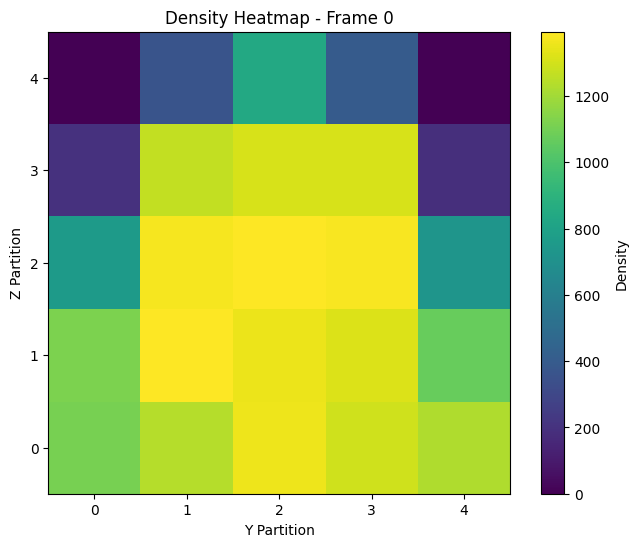

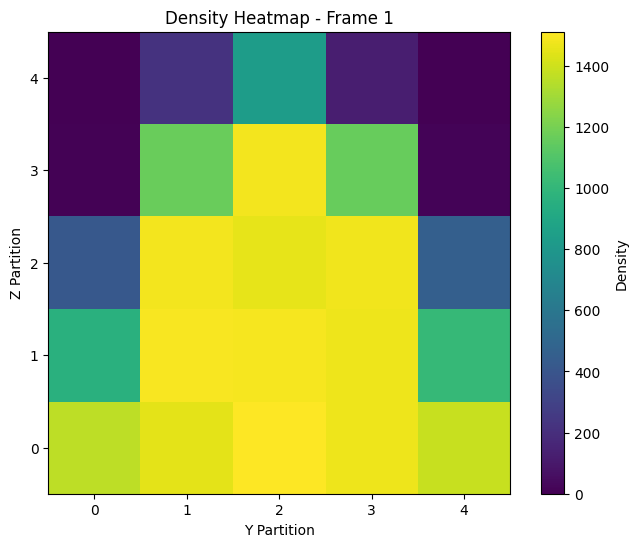

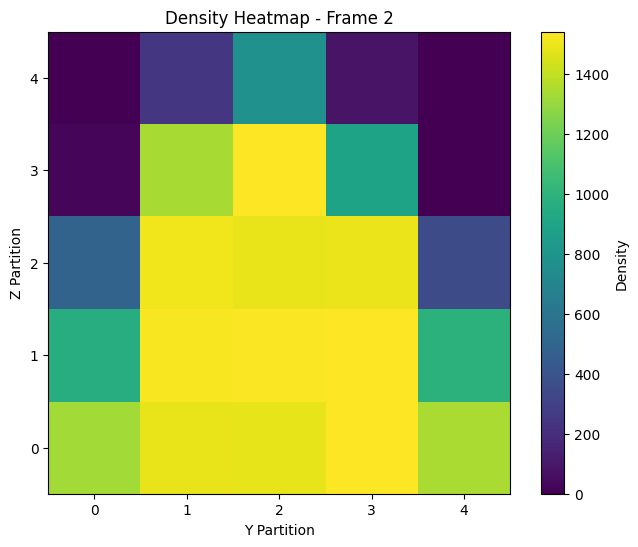

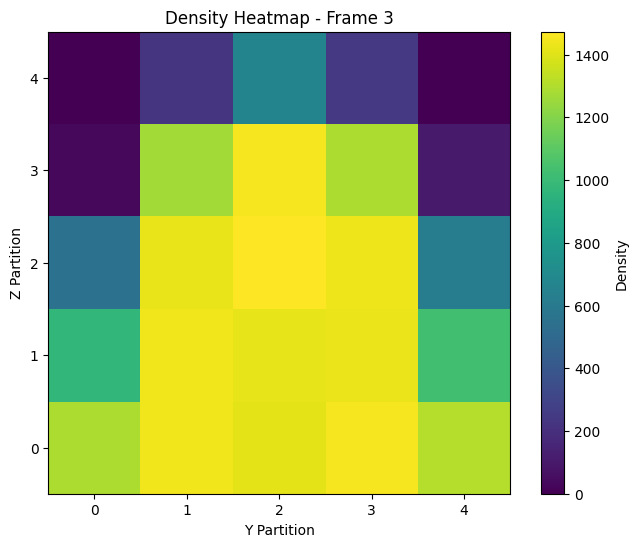

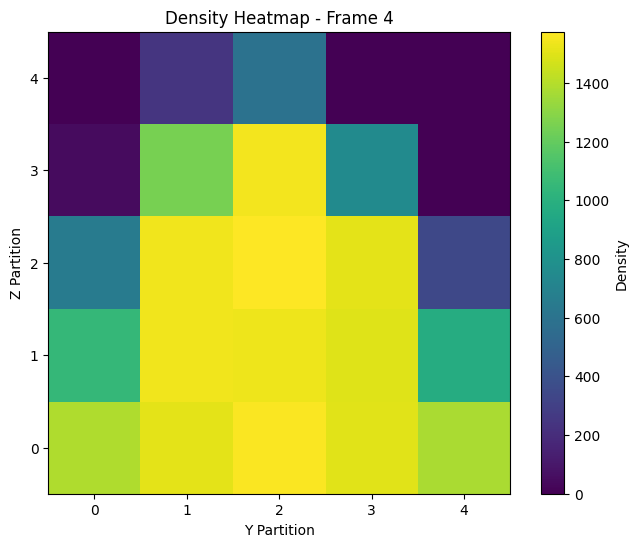

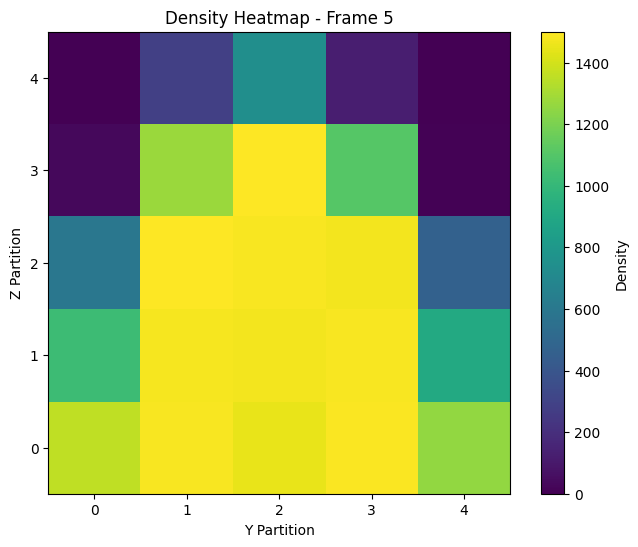

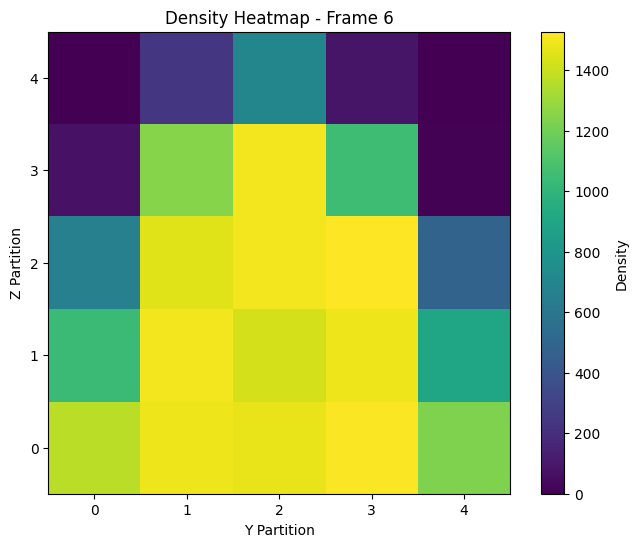

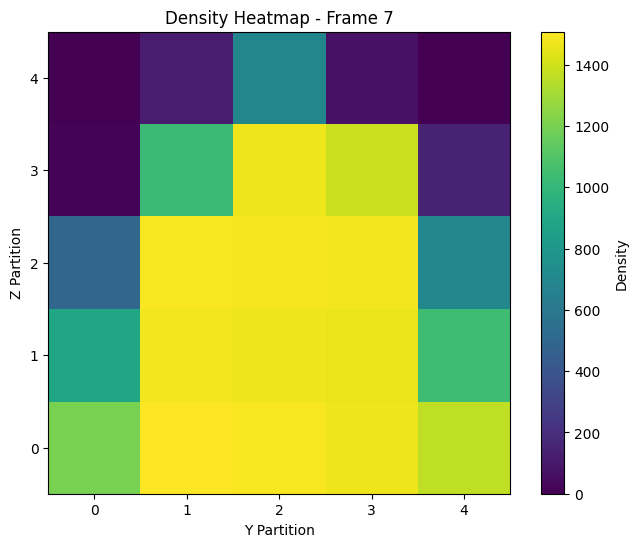

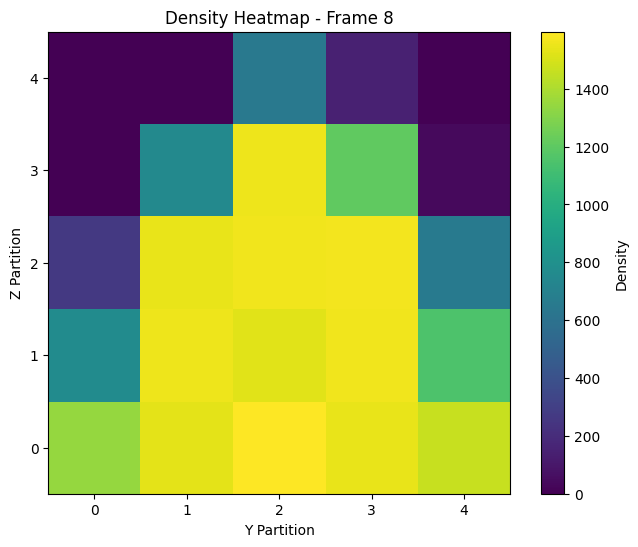

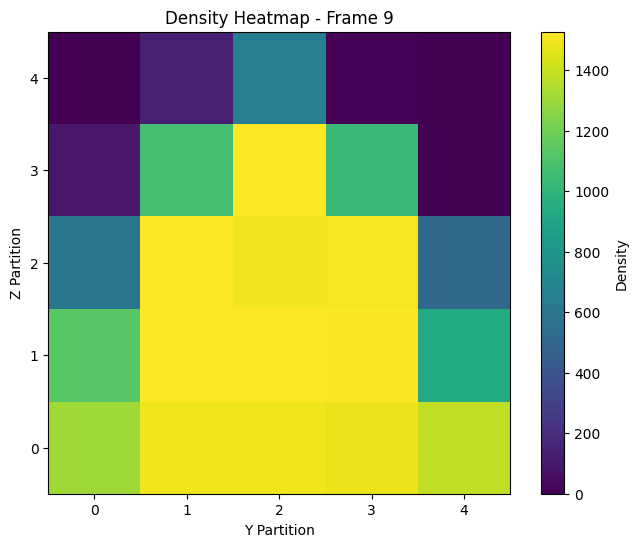

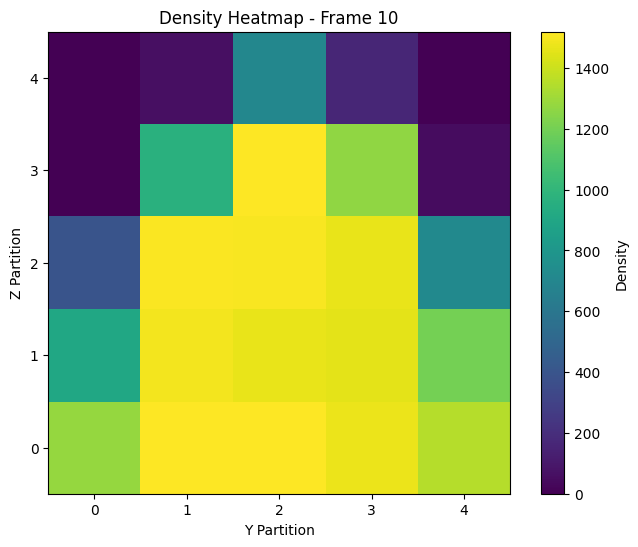

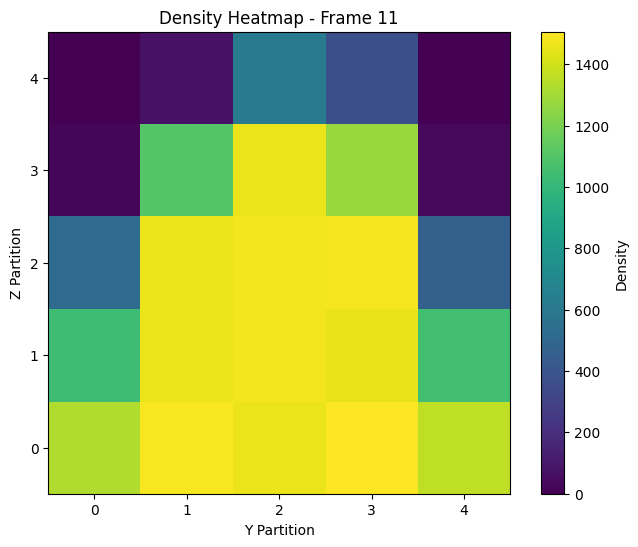

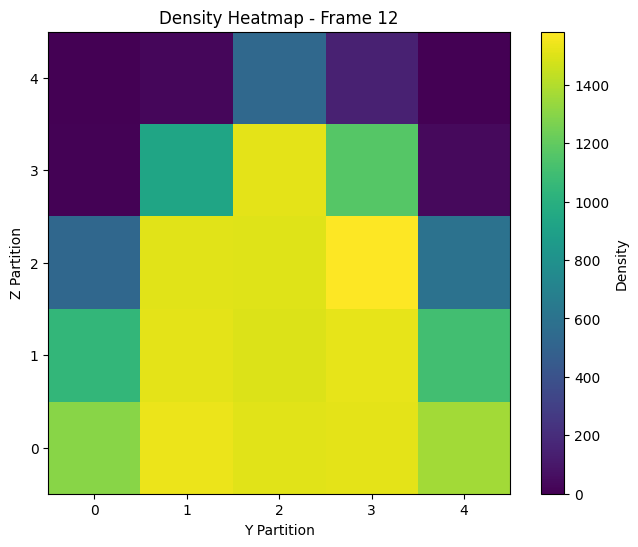

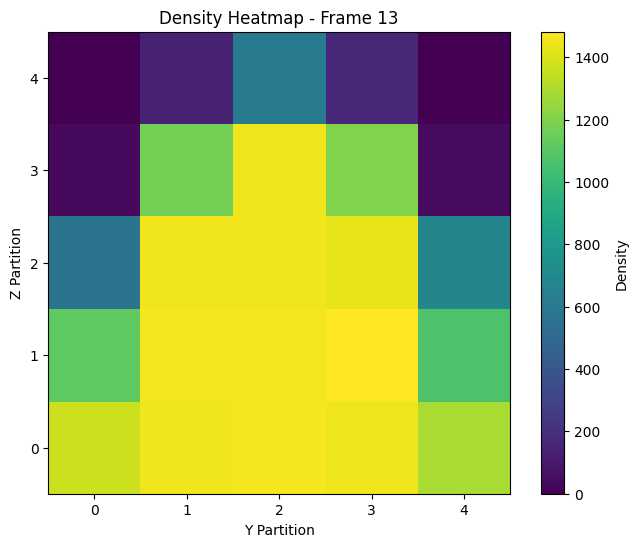

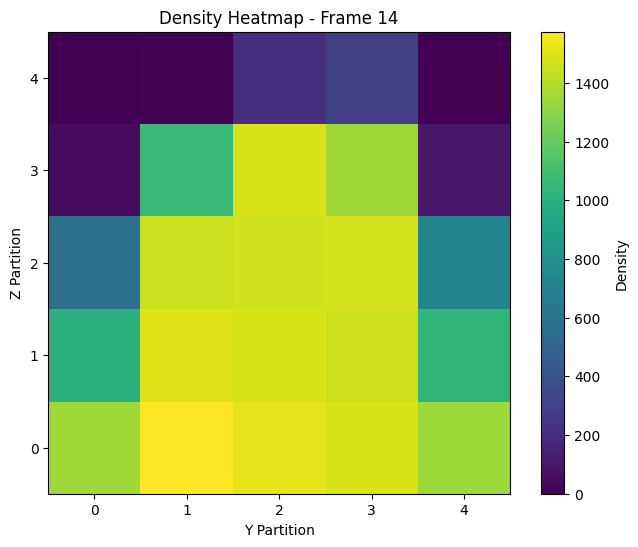

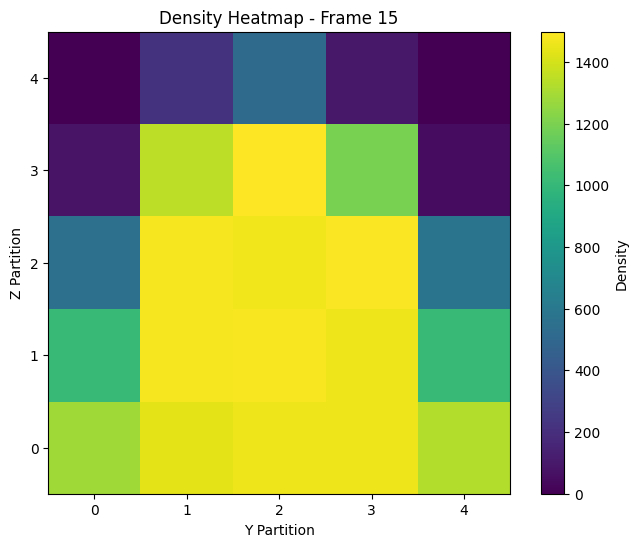

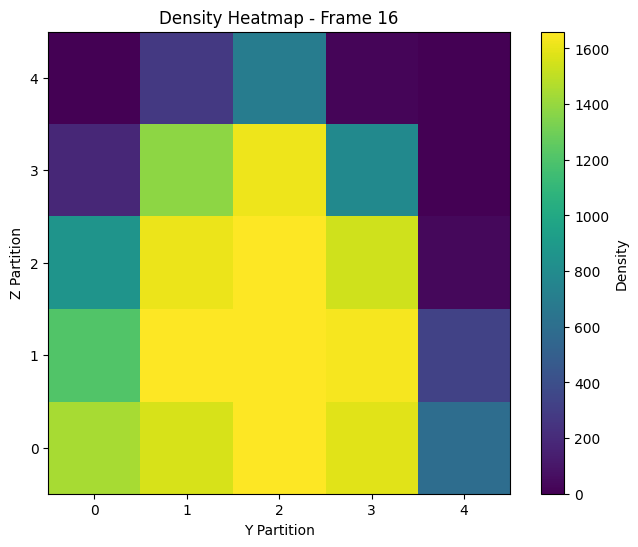

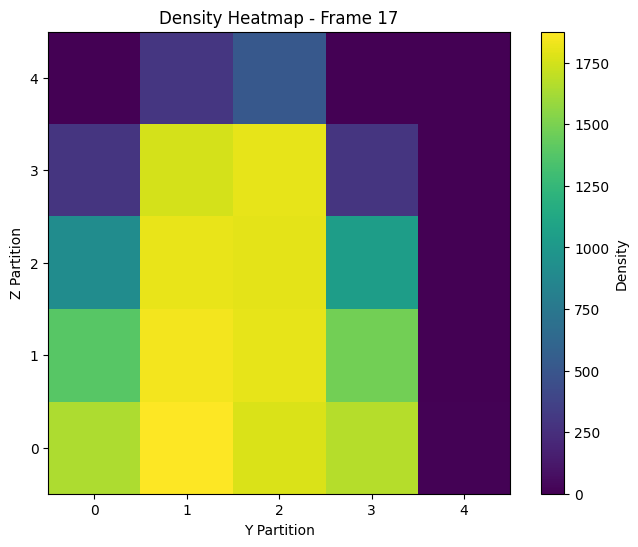

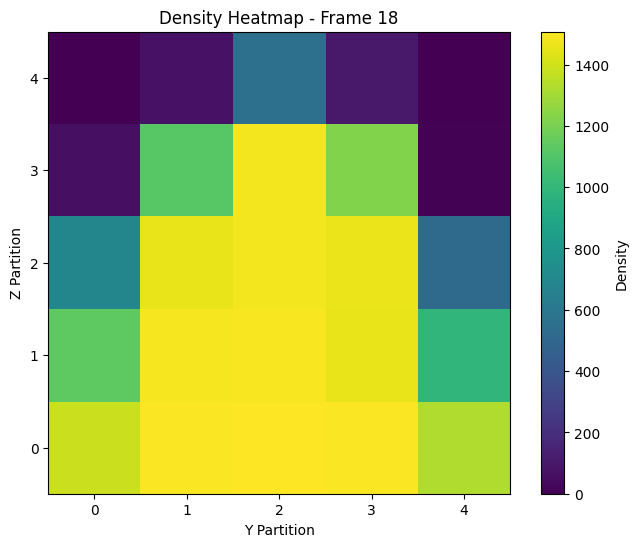

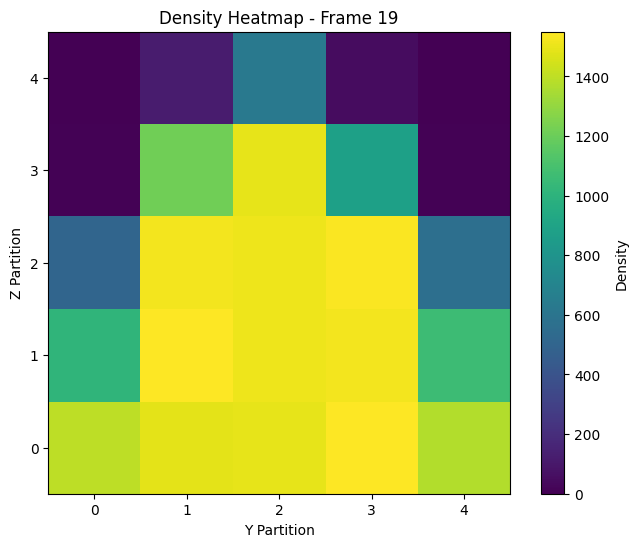

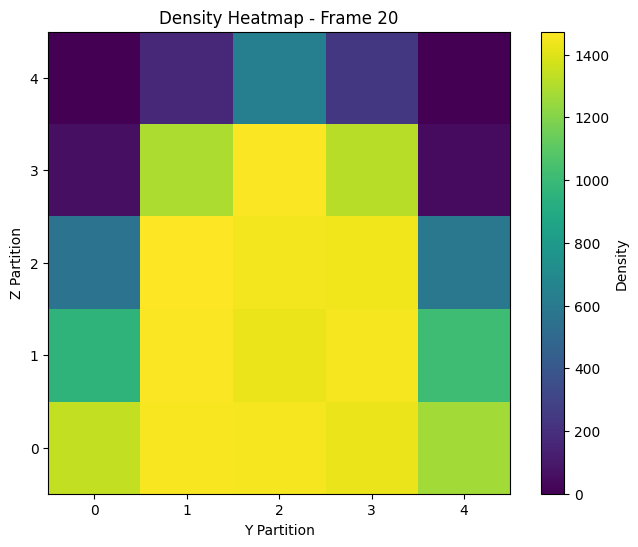

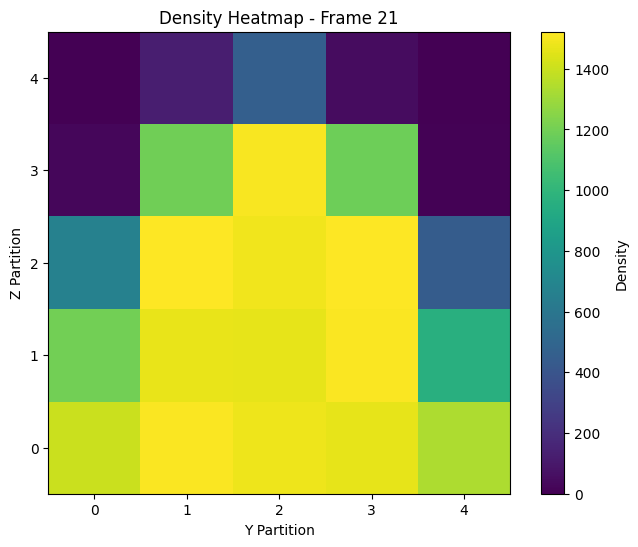

In [9]:
# Define the number of y and z partitions
num_y_partitions = int(1 / partition_percentage)
num_z_partitions = int(1 / partition_percentage)

# Create an empty array to store the density values
density_heatmap = np.zeros((len(global_uni.trajectory), num_y_partitions, num_z_partitions))

# Calculate density for each partition for each frame
for frame in partitioned_filtered_positions.keys():
    for y_part in partitioned_filtered_positions[frame].keys():
        for z_part in partitioned_filtered_positions[frame][y_part].keys():
            # Calculate the density as the number of atoms in the partition
            density = len(partitioned_filtered_positions[frame][y_part][z_part]['x_vals'])
            density_heatmap[frame][y_part][z_part] = density


# Plotting the heatmap and saving it
for frame in range(len(global_uni.trajectory)):

    plt.figure(figsize=(8, 6))
    plt.imshow(density_heatmap[frame].T, cmap='viridis', interpolation='nearest')
    plt.colorbar(label='Density')
    plt.xlabel('Y Partition')
    plt.ylabel('Z Partition')
    plt.gca().invert_yaxis()  # Reverse the y-axis
    plt.title(f'Density Heatmap - Frame {frame}')
    
    subdirectory = r'C:\Users\jeffs\Downloads\SZvsWorkspaceUpper\SZvsWorkspace\Research\Project2WettingAngle\ProgramOutputs\frame_density'
    plot_path = os.path.join(subdirectory, f'density_heatmap{frame}.png')
    #plt.savefig(plot_path)

    #plt.show()
    #plt.close()

    '''
    if frame < 1:
        plt.show()
        plt.close()
    else:
        plt.close()
    '''


In [10]:
min_allowed_edge_density = []

for frame in range(len(global_uni.trajectory)):
    min_allowed_edge_density.append(sum(overall_density[frame][int(1/partition_percentage/2)]['atom_count'][int(1/partition_percentage/2 - 3):int(1/partition_percentage/2 + 1)]) / 4 * .80)
# Finding the numeric value for the density we are defining the edge of the water droplet to have

In [11]:
max_density = {} # {Frame_n:[[y_part, tallest_min_dense_in_y_part_index],...]}

for i in range(len(global_uni.trajectory)): # Iterating through each frame
    max_density[i] = [] # Setting up data structure
    for j in range(len(overall_density[i])): # Iterating through each y partition
        for k in range(len(overall_density[i][j]['atom_count'])): # Iterating through each z partition
            if overall_density[i][j]['atom_count'][-k-1] >= min_allowed_edge_density[i]: # Checking if an atom in the current y,z partition has the density requested
                max_density[i].append([round(j * (ts_partition_lengths[i][1]),2),round(int(1/partition_percentage - k) * (ts_partition_lengths[i][2]),2)])
                break

C:\Users\jeffs\AppData\Local\Temp\ipykernel_3476\3282313730.py:14: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots()


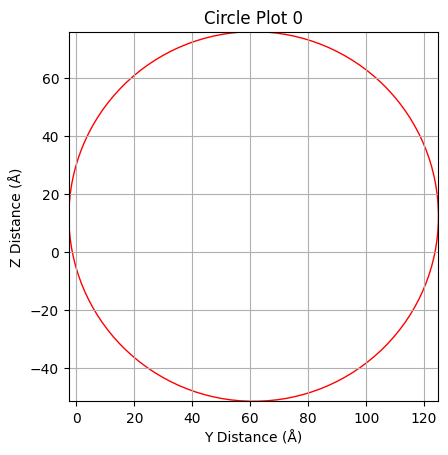

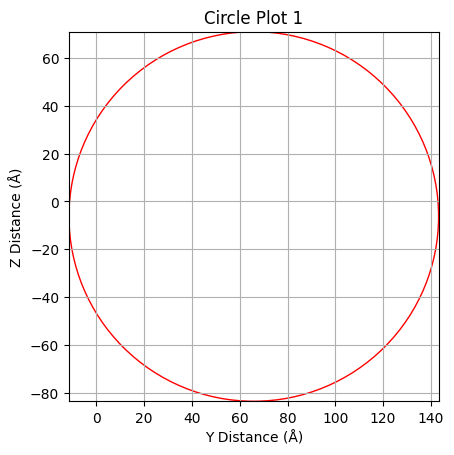

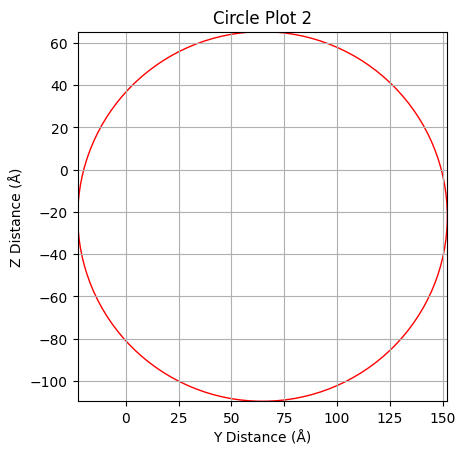

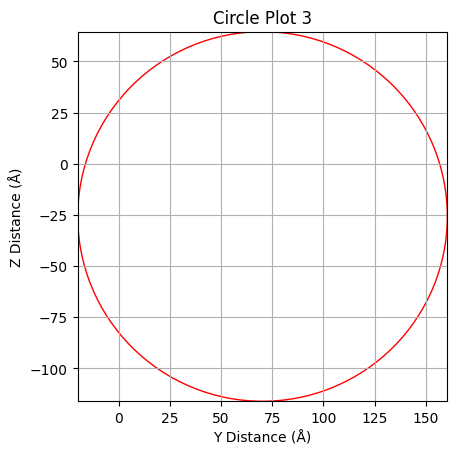

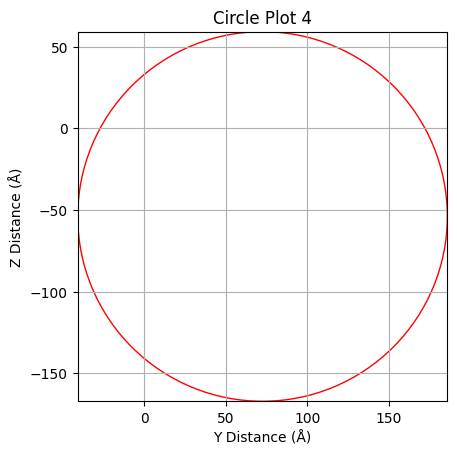

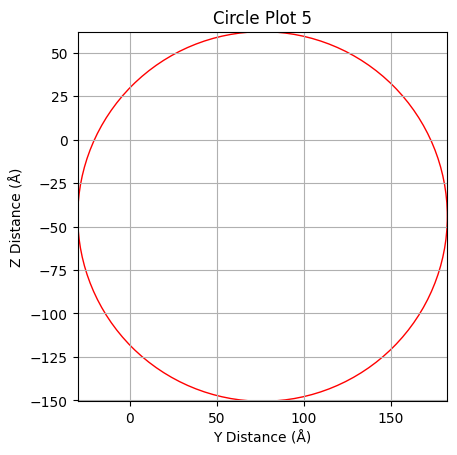

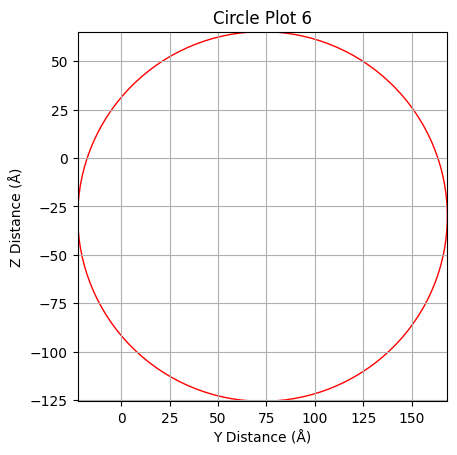

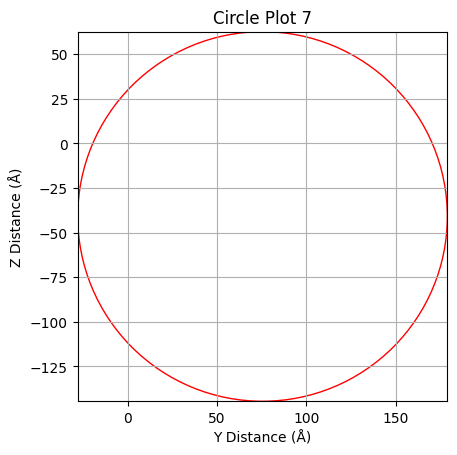

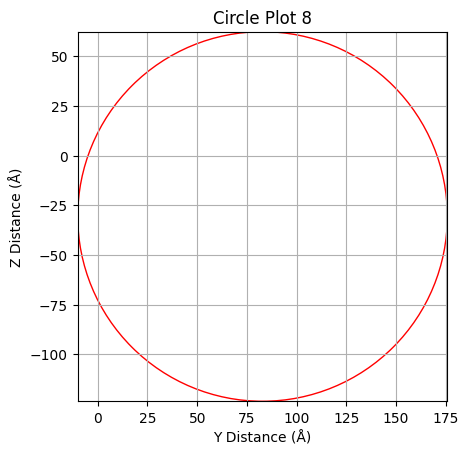

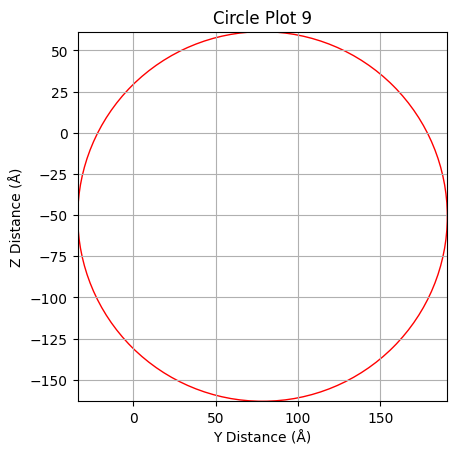

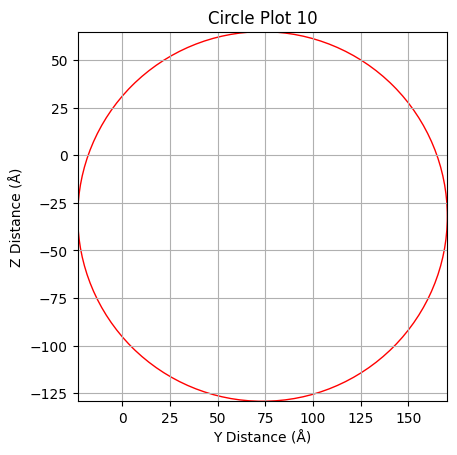

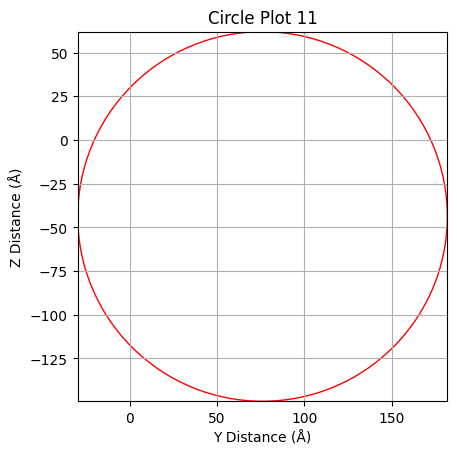

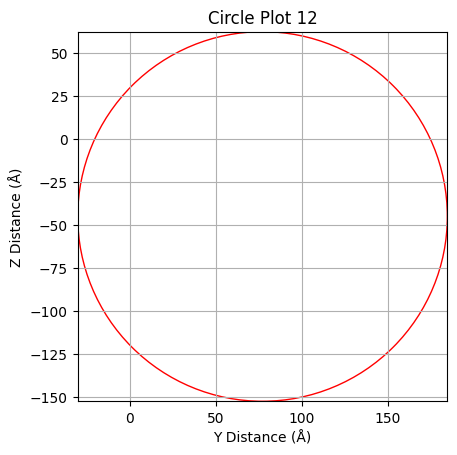

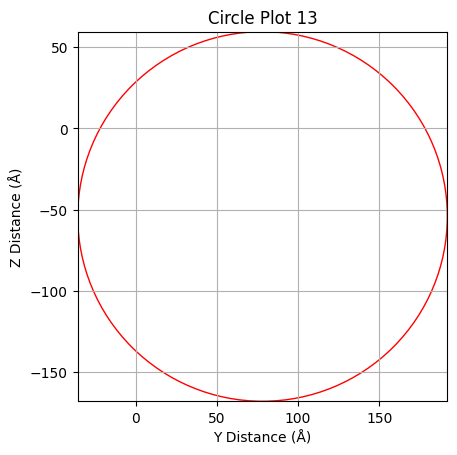

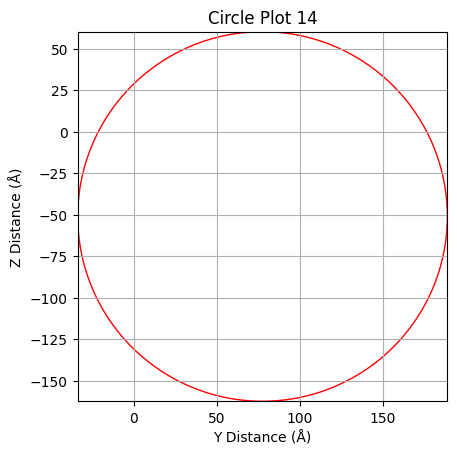

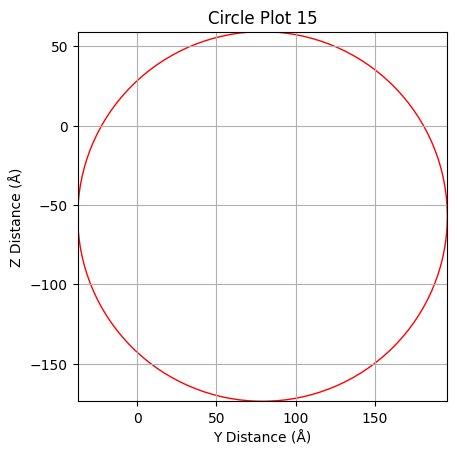

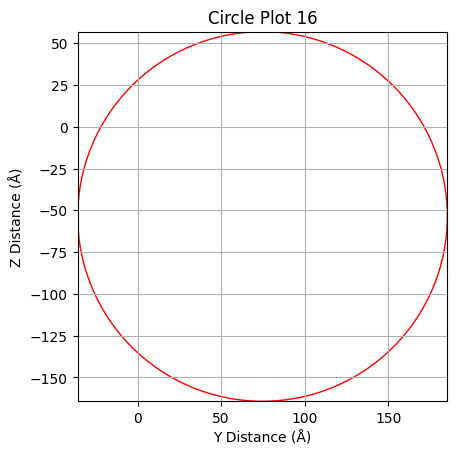

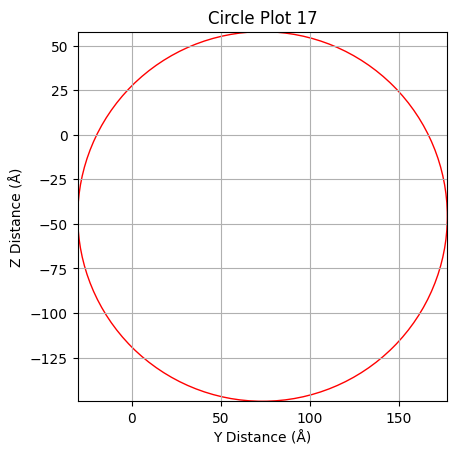

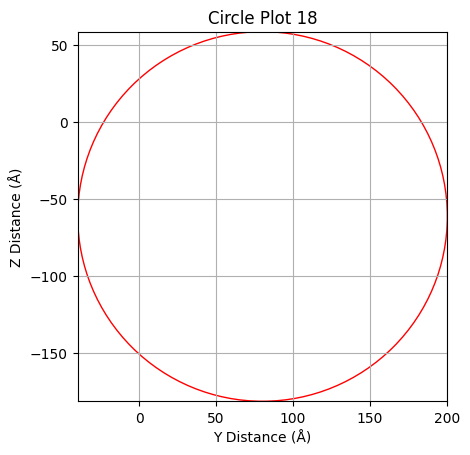

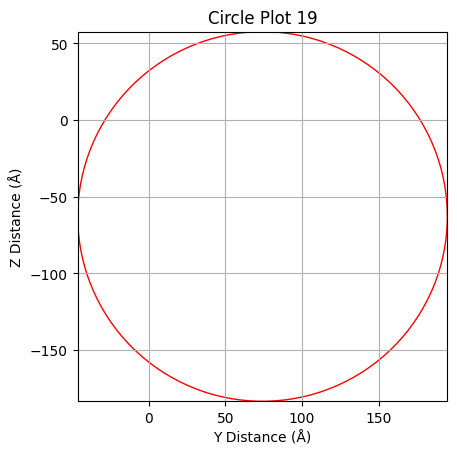

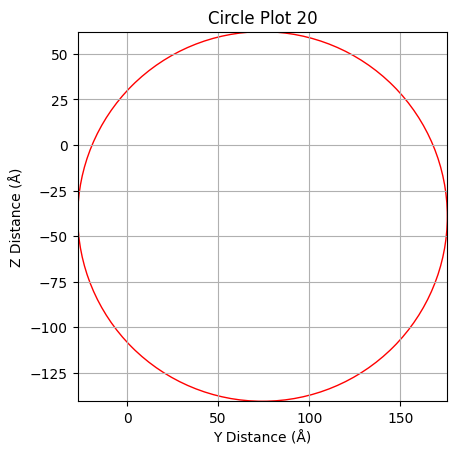

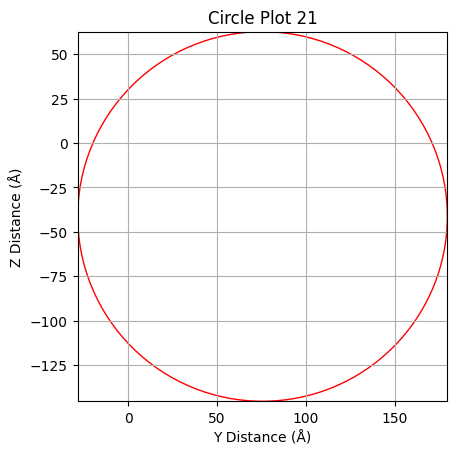

In [12]:
frame_wetting_angle = {} # {Frame_n : theta}

for frame in range(len(global_uni.trajectory)):
    # Define the center position (x0, y0) and the radius
    x0, y0, radius, junk = cf.standardLSQ(max_density[frame])

    first_zero = (float(radius)**2 - float(y0)**2)**(1/2) + float(x0)
    left_slope = 1/((radius**2 / (first_zero - x0)**2 - 1) )**(1/2)
    theta = math.atan(left_slope) * 180 / math.pi
    frame_wetting_angle[frame] = theta
    # Calculating wetting angle from derivative at circle's zero
    
    # Create a figure and axis
    fig, ax = plt.subplots()

    # Plot the circle
    circle = Circle((x0, y0), radius, edgecolor='r', facecolor='none')  # Create a circle patch
    ax.add_patch(circle)  # Add the circle patch to the axis

    # Set equal aspect ratio to make the circle appear circular
    ax.set_aspect('equal', adjustable='box')

    # Set labels and title
    ax.set_xlabel('Y Distance (Å)')
    ax.set_ylabel('Z Distance (Å)')
    ax.set_title(f'Circle Plot {frame}')

    # Set limits to include the circle
    ax.set_xlim(x0 - radius, x0 + radius)
    ax.set_ylim(y0 - radius, y0 + radius)

    # Show the plot
    plt.grid(True)
    subdirectory = r'C:\Users\jeffs\Downloads\SZvsWorkspaceUpper\SZvsWorkspace\Research\Project2WettingAngle\ProgramOutputs\fitting_methods'
    plot_path = os.path.join(subdirectory, f'best_fit_circle{frame}.png')
    #plt.savefig(plot_path)

    #plt.show()
    #plt.close()

    '''
    if frame < 1:
        plt.show()
        plt.close()
    else:
        plt.close()
    '''


#Use circles of best fit to match the outside of a water droplet

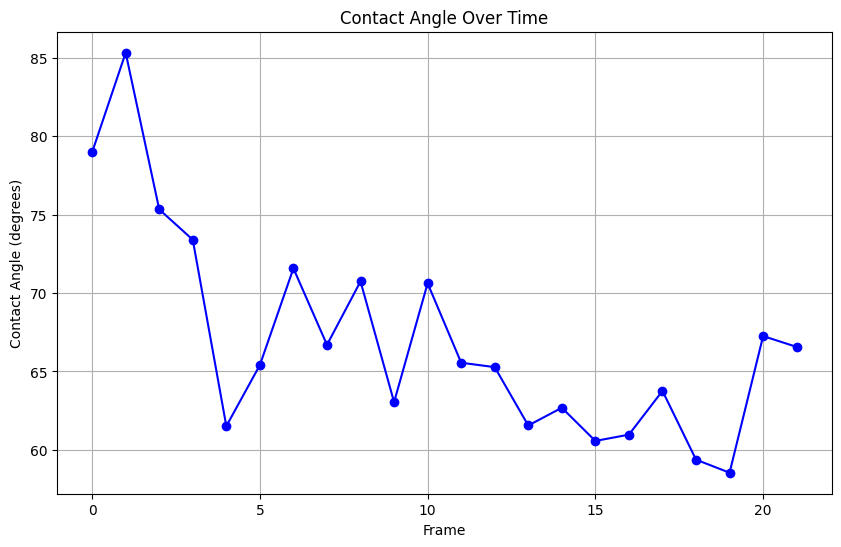

In [13]:
total_angle = 0
x_vals = list(frame_wetting_angle.keys())
y_vals = []

for frame in frame_wetting_angle.keys():
    total_angle += frame_wetting_angle[frame]
    y_vals.append(frame_wetting_angle[frame])
# Print out wetting angle for each frame and sum all wetting angles in order to average and create y_val list

plt.figure(figsize=(10, 6))
plt.plot(x_vals, y_vals, marker='o', linestyle='-', color='b')
plt.xlabel('Frame')
plt.ylabel('Contact Angle (degrees)')
plt.title('Contact Angle Over Time')
plt.grid(True)
plt.show()
# Plot Contact angle over times

In [14]:
eyeballed_relaxation_time = 13

equilibrium_frames, equilbrium_angles = x_vals[eyeballed_relaxation_time:], y_vals[eyeballed_relaxation_time:]
eq_contact_angle = np.mean(equilbrium_angles)
fluctuations = np.std(equilbrium_angles)

print(f'Average Theta: {round(total_angle / len(frame_wetting_angle.keys()),2)} | Relaxation Time: {eyeballed_relaxation_time} | Equilibrium Contact Angle: {round(eq_contact_angle,2)} | Fluctuation Angle: {round(fluctuations,2)}')
# Print out data about wetting angle throughout simulation using best fit circle

Average Theta: 67.03 | Relaxation Time: 13 | Equilibrium Contact Angle: 62.36 | Fluctuation Angle: 2.85


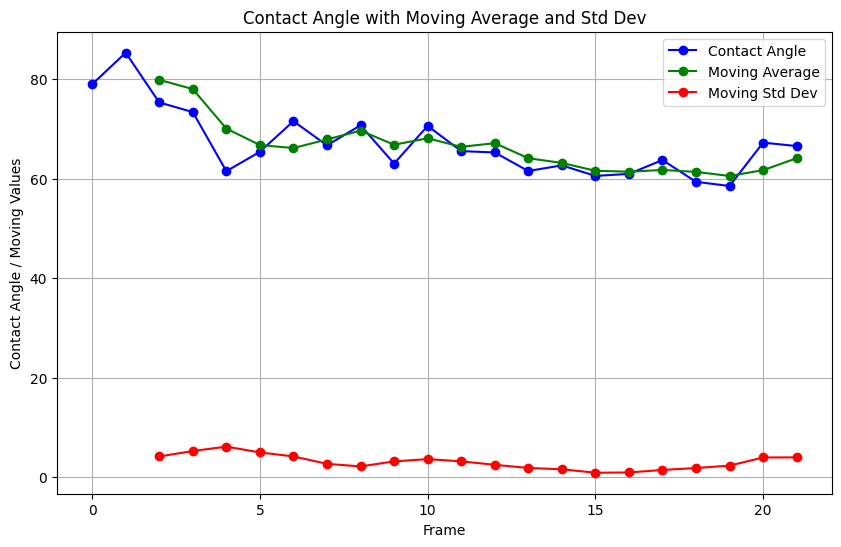

In [15]:
window_size = 3
moving_avg = []
moving_std = []
for i in range(len(y_vals) - window_size + 1):
    window = y_vals[i:i + window_size]
    moving_avg.append(np.mean(window))
    moving_std.append(np.std(window))

# Plotting the results
plt.figure(figsize=(10, 6))
plt.plot(x_vals, y_vals, marker='o', linestyle='-', color='b', label='Contact Angle')
plt.plot(x_vals[window_size-1:], moving_avg, marker='o', linestyle='-', color='g', label='Moving Average')
plt.plot(x_vals[window_size-1:], moving_std, marker='o', linestyle='-', color='r', label='Moving Std Dev')
plt.xlabel('Frame')
plt.ylabel('Contact Angle / Moving Values')
plt.title('Contact Angle with Moving Average and Std Dev')
plt.legend()
plt.grid(True)
plt.show()


In [16]:
density_positions = {}

for frame in range(len(global_uni.trajectory)):
    density_positions[frame] = []
    
    for i in range(len(max_density[frame])):
        density_positions[frame].append((max_density[frame][i][0],max_density[frame][i][1]))

print(density_positions[0])

[(0.0, 32.34), (30.58, 64.68), (61.16, 80.86), (91.74, 64.68), (122.32, 32.34)]


In [17]:
for frame in range(len(global_uni.trajectory)):

    unrefined_y_frame_pos = []
    for coord in density_positions[frame]:
        unrefined_y_frame_pos.append(coord[1])

    if density_positions[frame][0][0] != 0:
        new_y_height = density_positions[frame][0][1] / 3
        new_coord_positions = (0.0, new_y_height)
        density_positions[frame].insert(0, new_coord_positions)
        
    if density_positions[frame][-1][1] >= max(unrefined_y_frame_pos) * .20:
        new_y_height = density_positions[frame][-1][1] / 3
        new_x_dist = density_positions[frame][-1][0] + abs(density_positions[frame][1][0] - density_positions[frame][0][0])
        new_coord_positions = (new_x_dist,new_y_height)
        density_positions[frame].append(new_coord_positions)

x_dict_reformated = {}
y_dict_reformated = {}
for frame in range(len(global_uni.trajectory)):
    x_dict_reformated[frame] = []
    y_dict_reformated[frame] = []
    for i in range(len(density_positions[frame])):
        x_dict_reformated[frame].append(density_positions[frame][i][0])
        y_dict_reformated[frame].append(density_positions[frame][i][1])

In [18]:
x_data = x_dict_reformated
y_data = y_dict_reformated

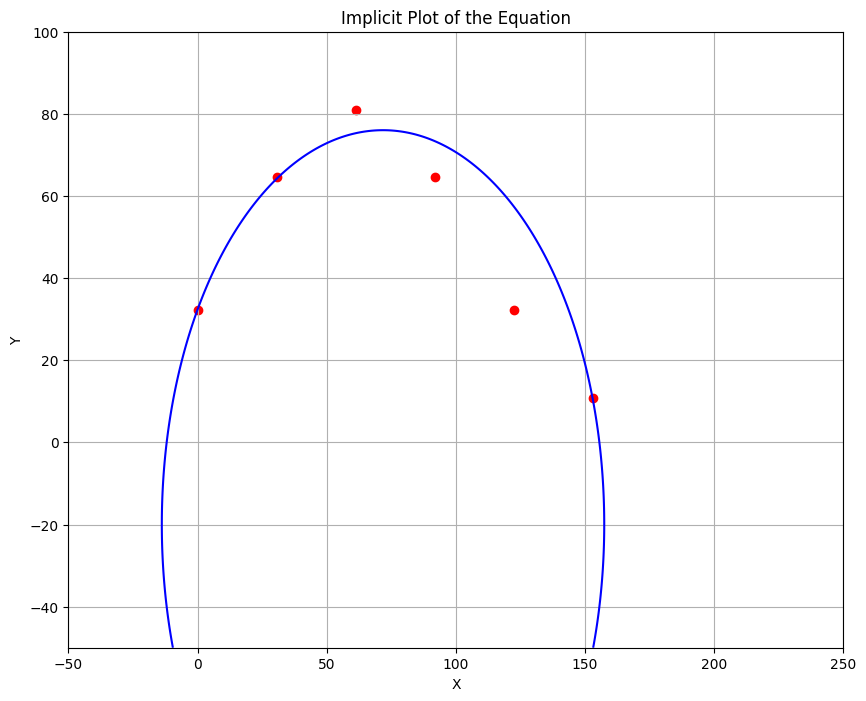

Optimal parameters: a=89.17430561324868, b=100.0, y_0=-20.0, C=0.23395671407049806, x_0=71.7896506470044
Angle: 79.16774079991366


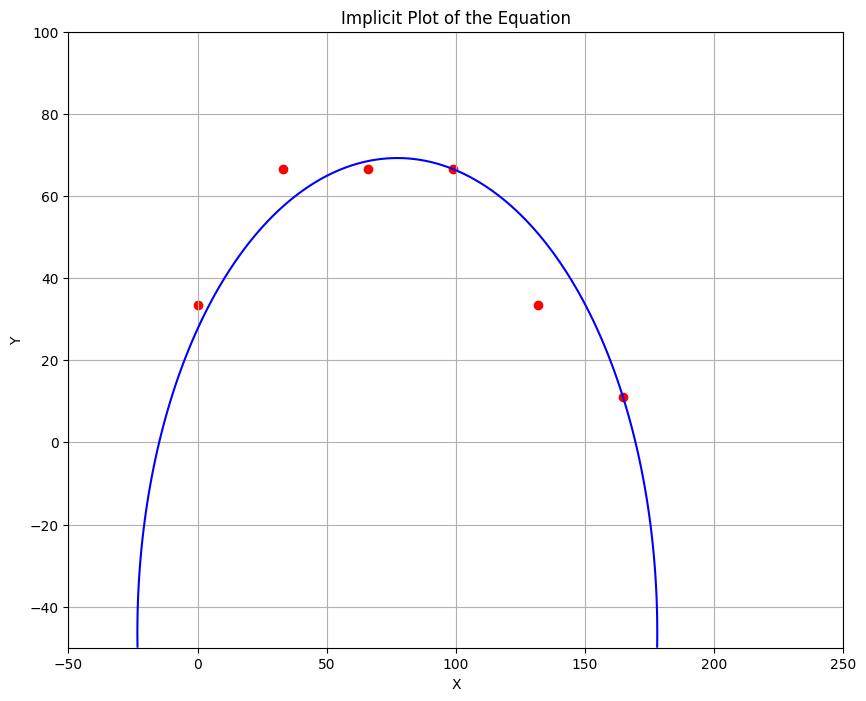

Optimal parameters: a=87.10991993974874, b=100.0, y_0=-46.27246386903289, C=0.3321828894938721, x_0=77.32500004420035
Angle: 68.99078681105753


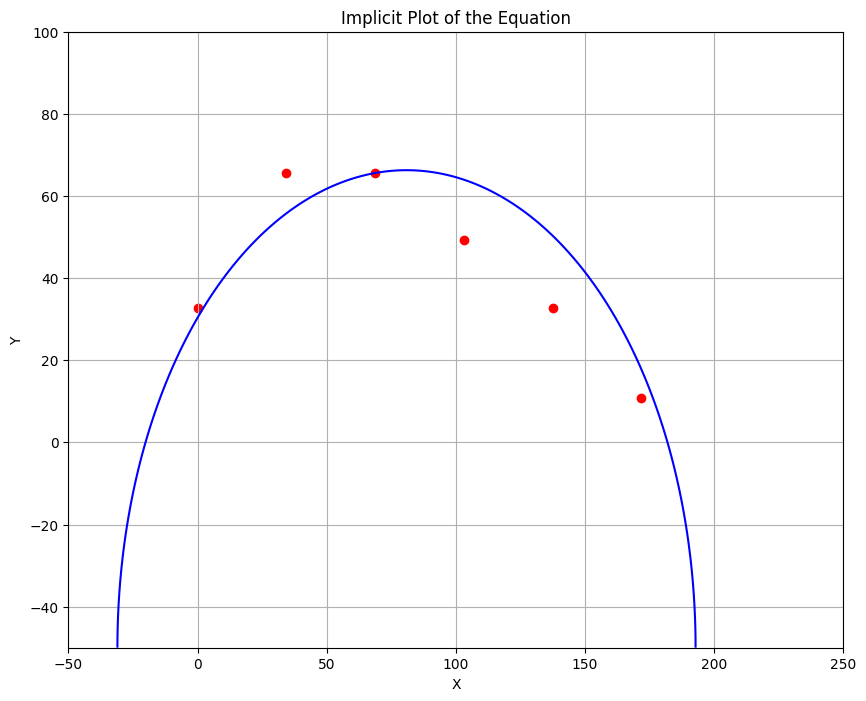

Optimal parameters: a=96.23449329782575, b=100.0, y_0=-50.0, C=0.39584658711995896, x_0=80.875
Angle: 65.16941148909221


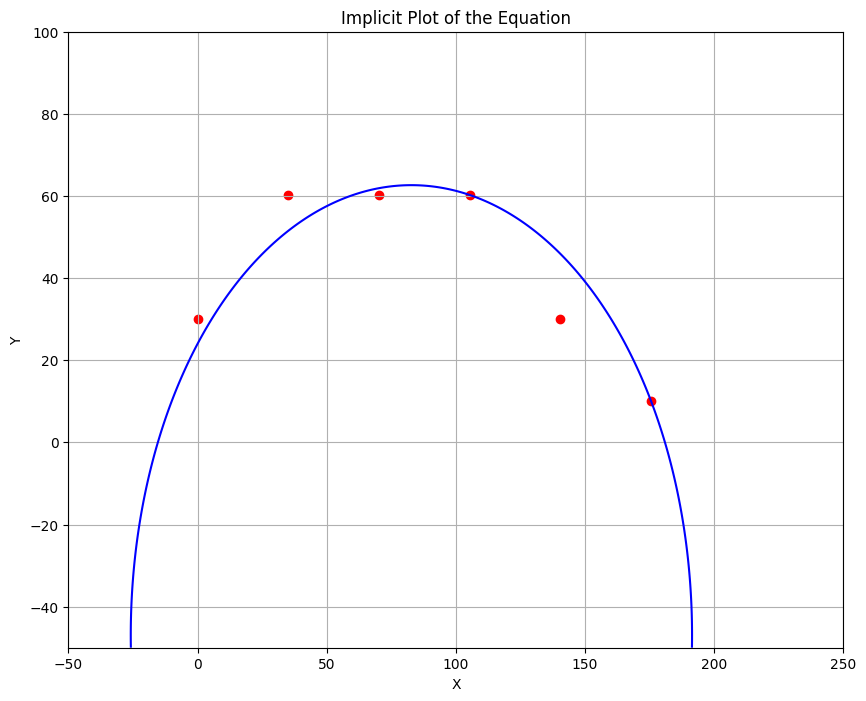

Optimal parameters: a=87.79542274296234, b=88.60310540447536, y_0=-46.99841462356088, C=0.3608502202814366, x_0=82.775
Angle: 64.64983159985945


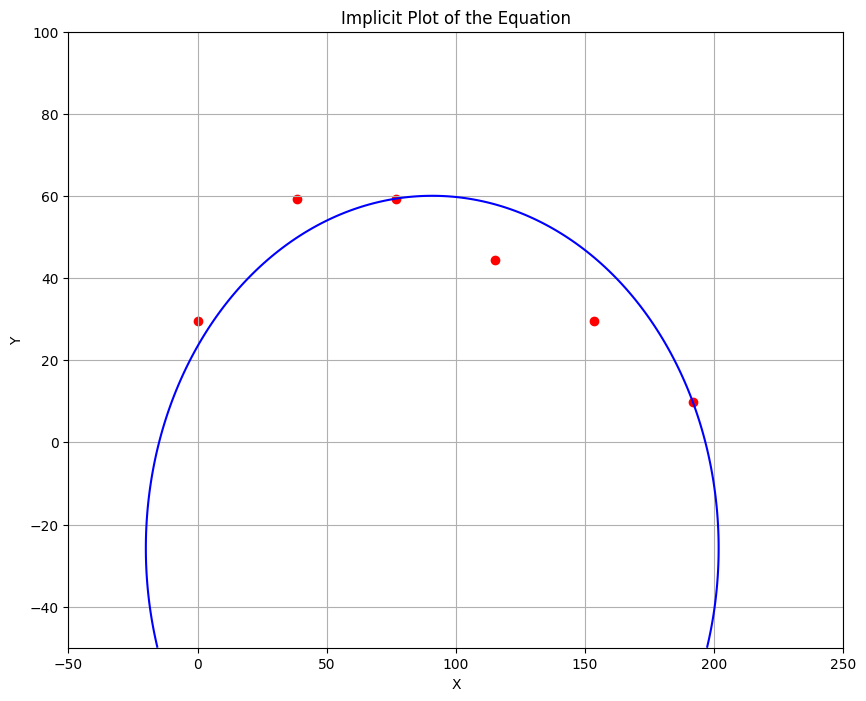

Optimal parameters: a=100.0, b=77.41594208779551, y_0=-25.779035443125363, C=0.2930019941002018, x_0=90.84
Angle: 67.73669649913897


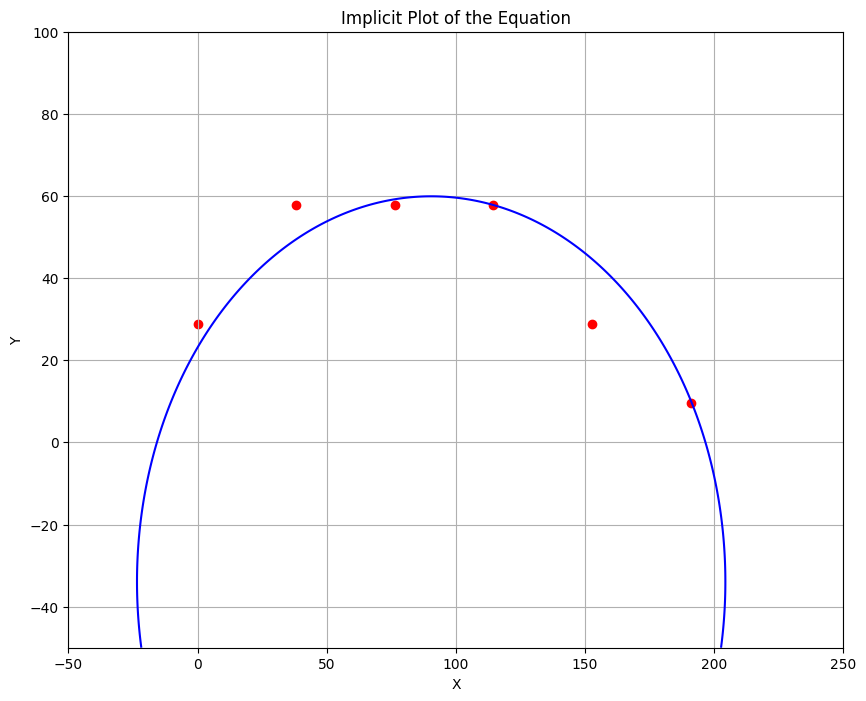

Optimal parameters: a=100.0, b=82.42918315043248, y_0=-33.9442689322518, C=0.3094806475406564, x_0=90.43
Angle: 64.65267172042219


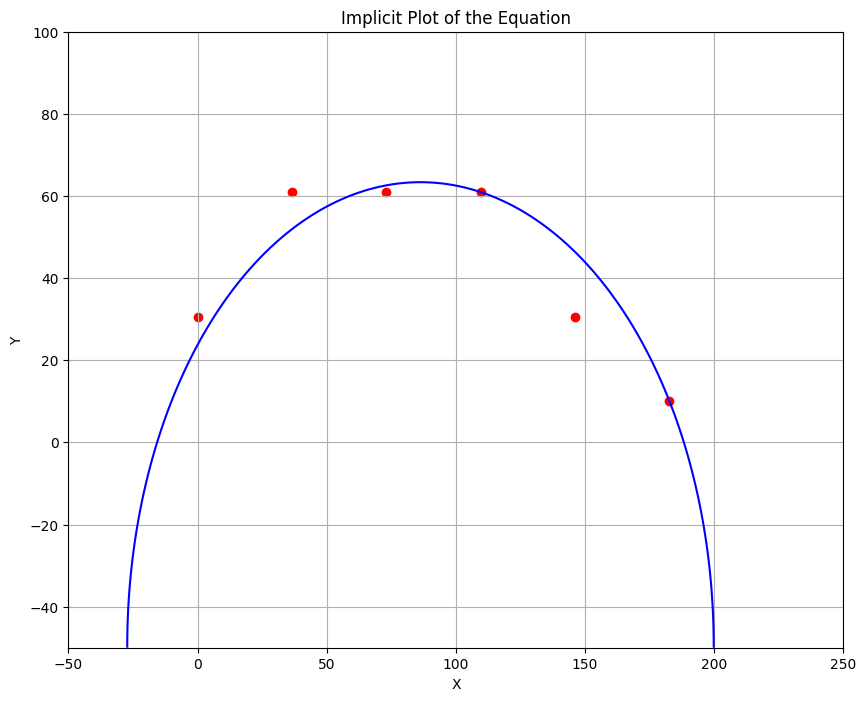

Optimal parameters: a=100.0, b=99.62180466980922, y_0=-49.72329167714532, C=0.29478334161166014, x_0=86.29000000175276
Angle: 63.66461395645963


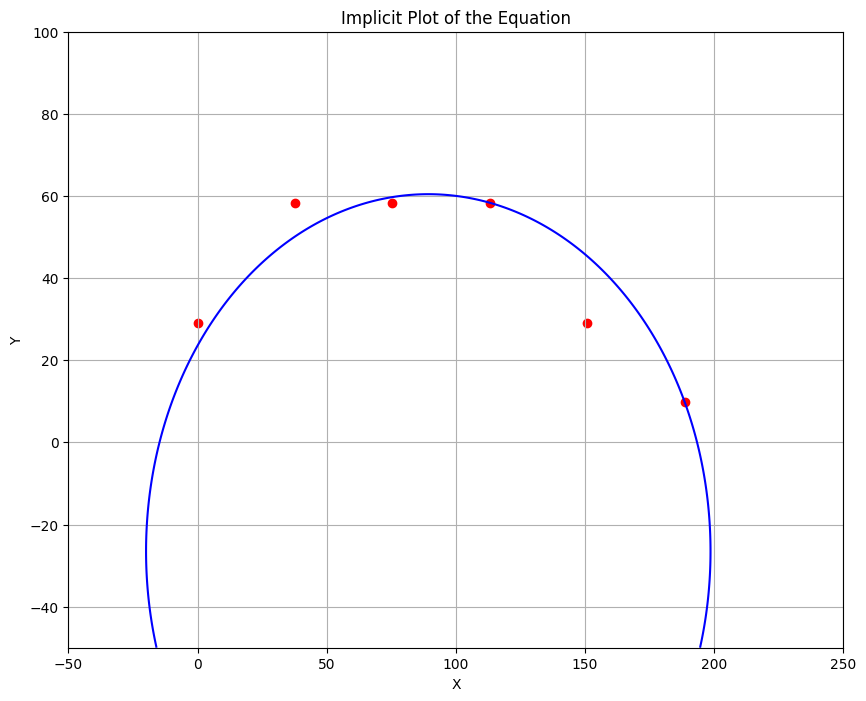

Optimal parameters: a=100.0, b=79.5953176024361, y_0=-26.519716775145184, C=0.28494575136564976, x_0=89.31
Angle: 67.95441040155127


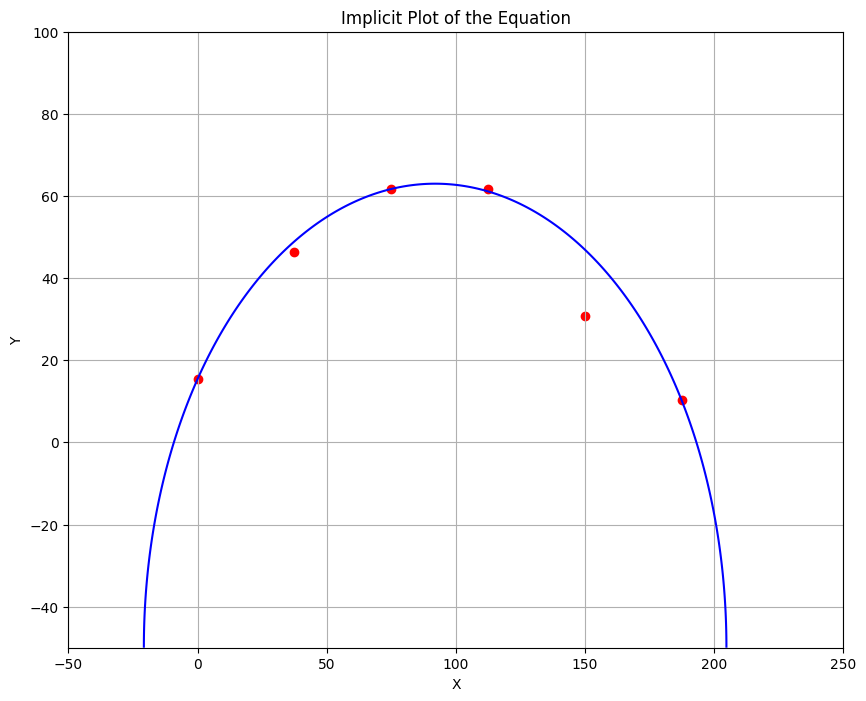

Optimal parameters: a=99.87467056279344, b=100.0, y_0=-49.902002494053704, C=0.17767422738110025, x_0=91.96388546375472
Angle: 63.761414952920795


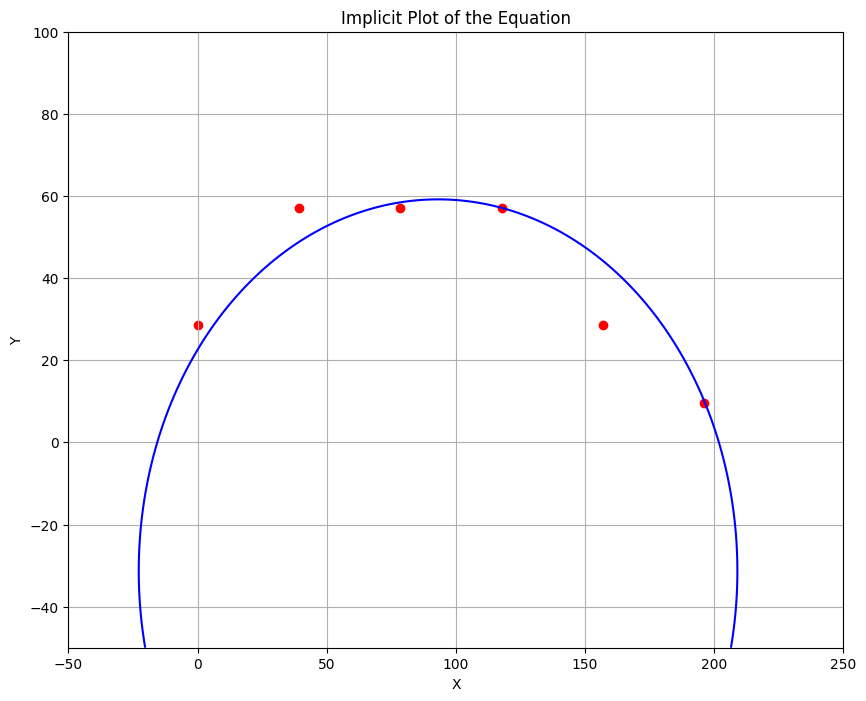

Optimal parameters: a=99.8053637809168, b=77.95202877080533, y_0=-31.316849414310095, C=0.3161828594337473, x_0=93.095
Angle: 64.5791200229637


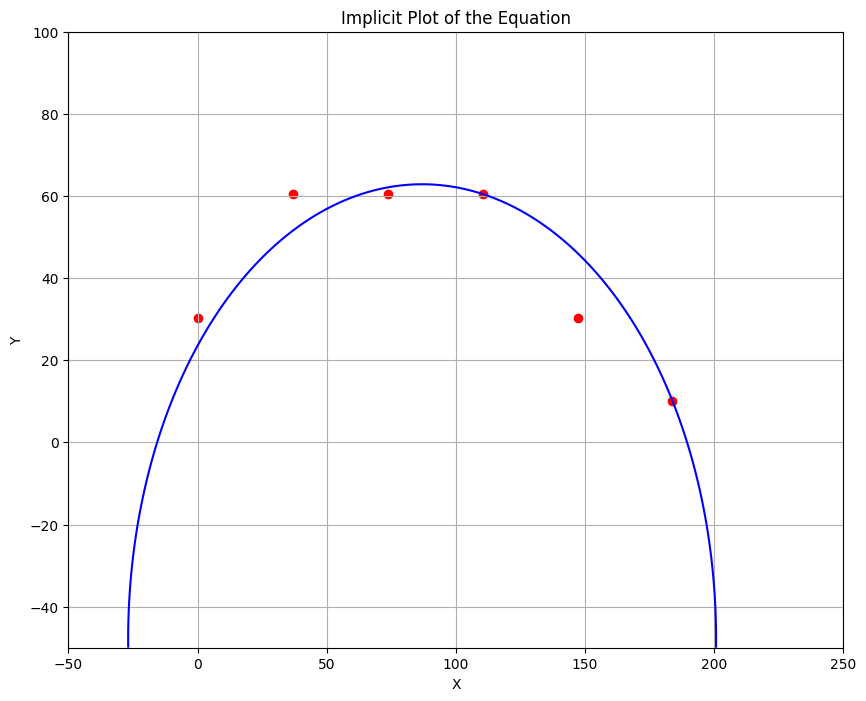

Optimal parameters: a=83.83698390759713, b=81.68165168629275, y_0=-48.010352125510096, C=0.42185736538696517, x_0=86.920000036422
Angle: 63.58888447012601


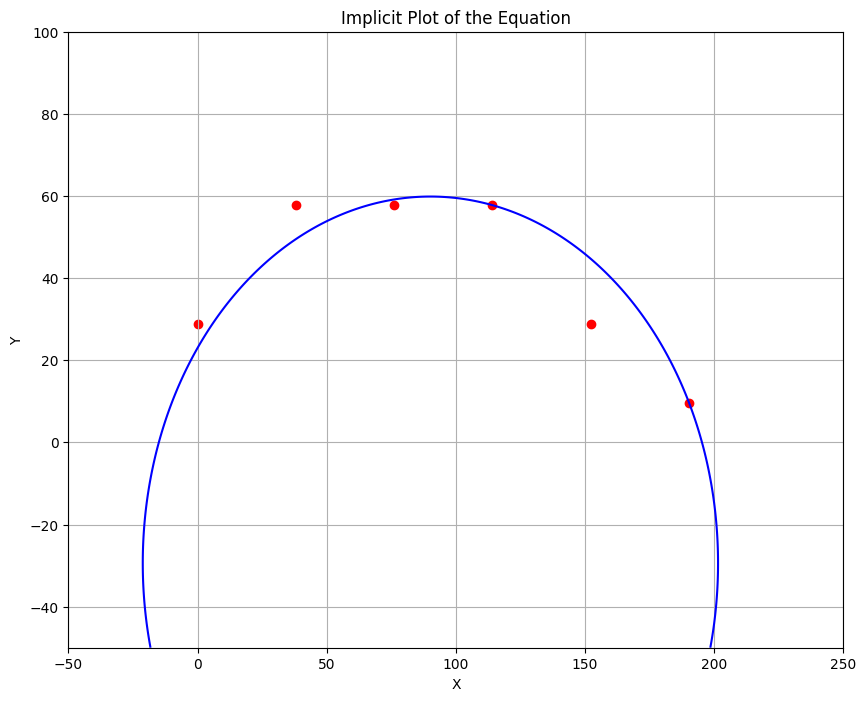

Optimal parameters: a=100.0, b=80.19414598642093, y_0=-29.427933450102636, C=0.2927709985819716, x_0=90.13
Angle: 66.34039869440022


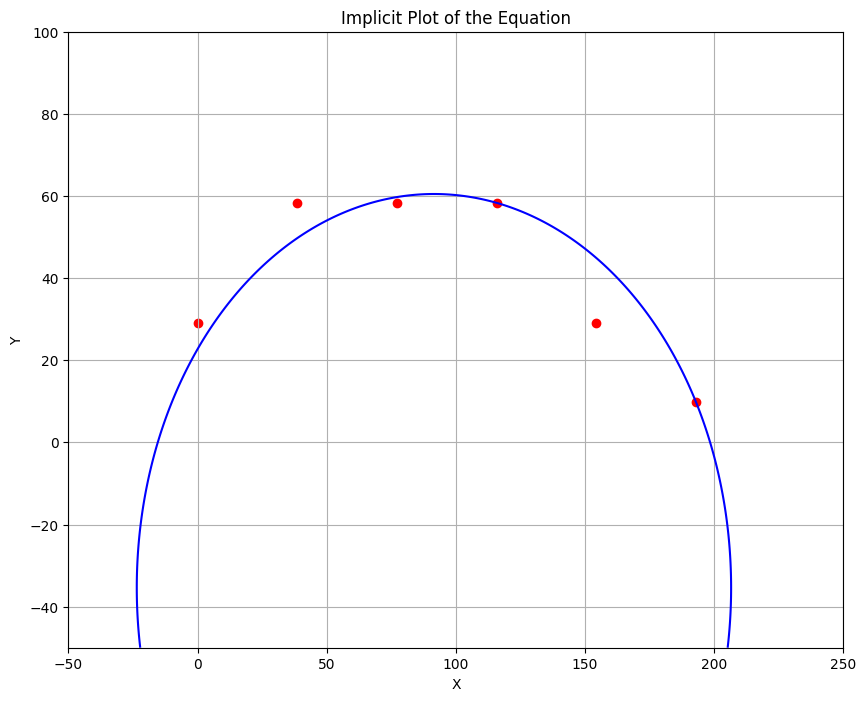

Optimal parameters: a=100.0, b=83.35710795630727, y_0=-35.405169543736704, C=0.3056524138402244, x_0=91.5
Angle: 64.3716349919481


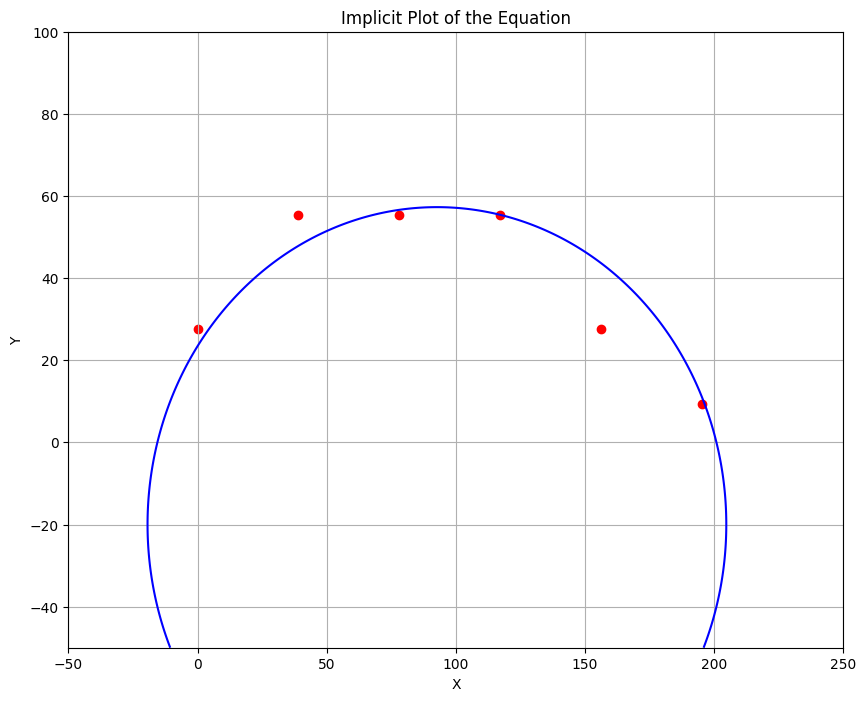

Optimal parameters: a=99.5334824395503, b=68.6728660592017, y_0=-20.0, C=0.31528523471422704, x_0=92.65000450205163
Angle: 68.65510526388456


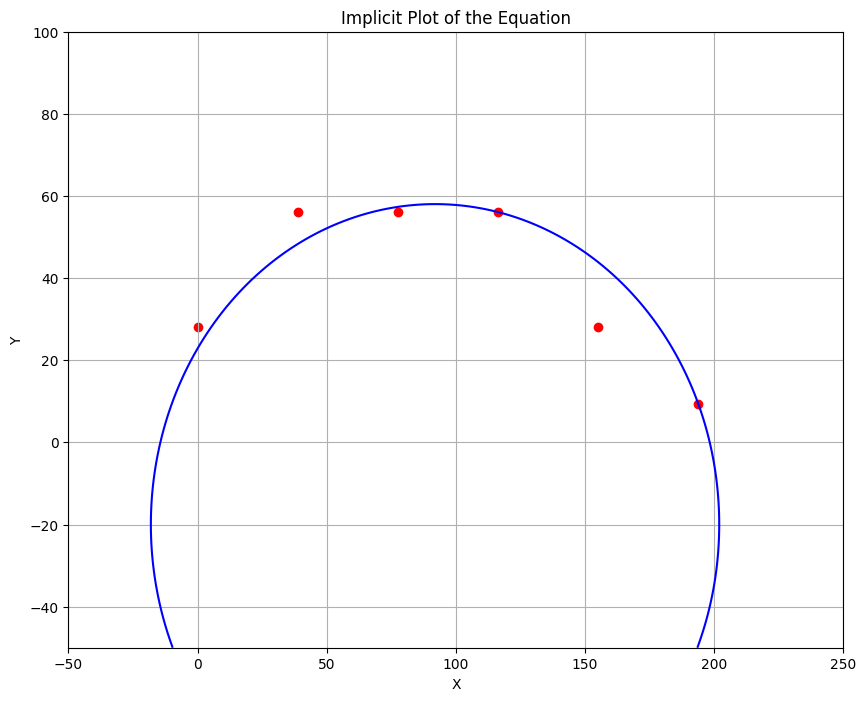

Optimal parameters: a=99.99999999999969, b=70.92622593841108, y_0=-20.0, C=0.2855355466239609, x_0=91.92500000000001
Angle: 69.38329318336483


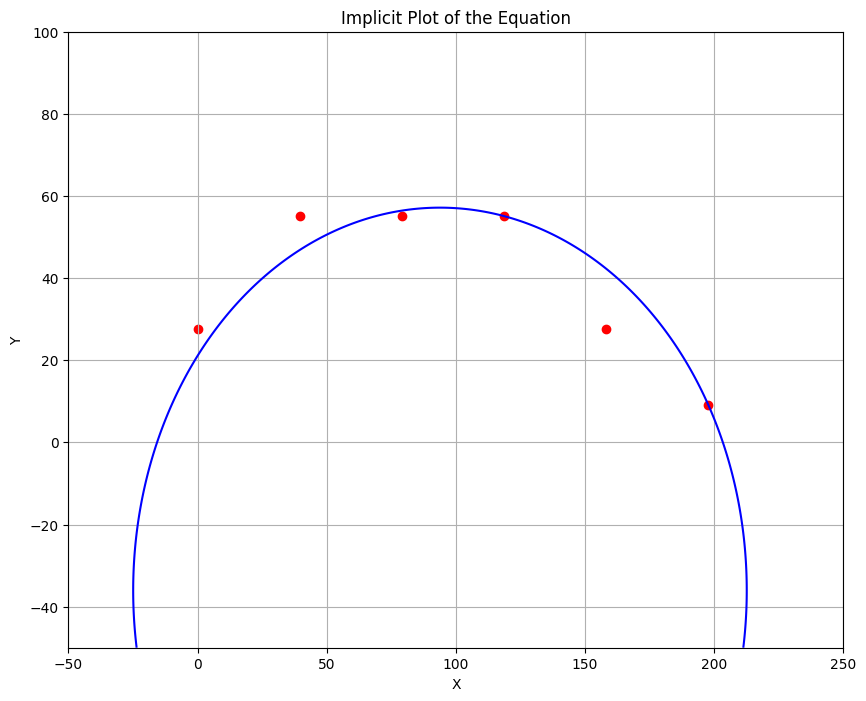

Optimal parameters: a=100.0, b=78.49943845299107, y_0=-36.06143357778724, C=0.3188288213526498, x_0=93.83000000010558
Angle: 61.73035785810472


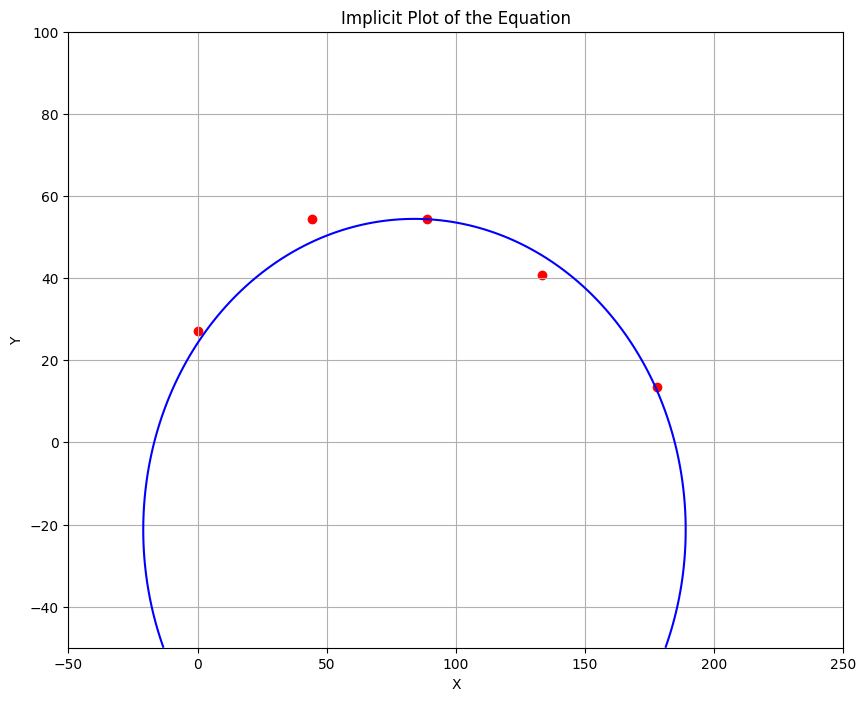

Optimal parameters: a=100.0, b=72.11582140011807, y_0=-21.286133473763652, C=0.3101703352565598, x_0=83.96
Angle: 67.73198476604286


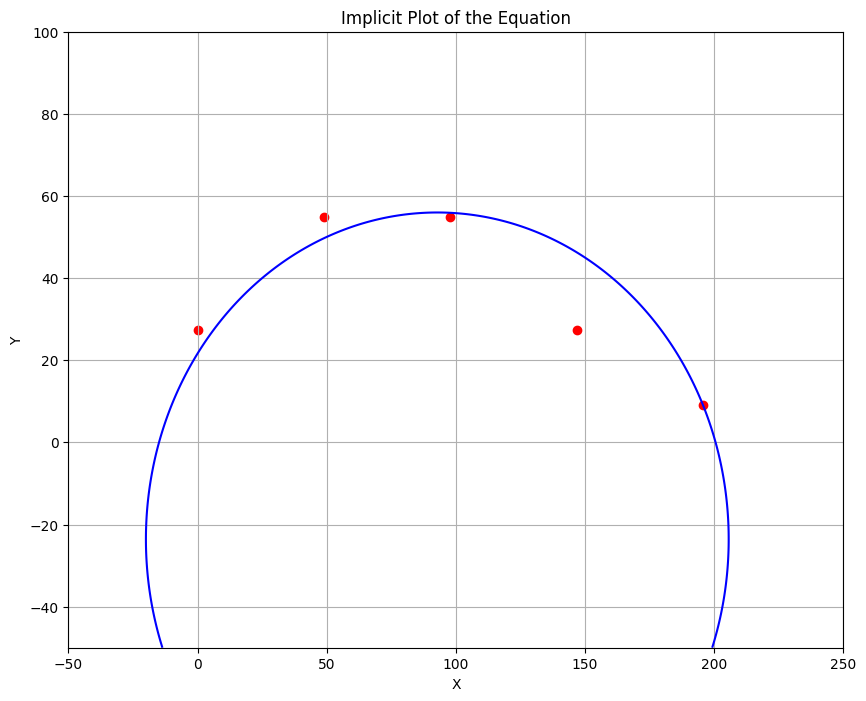

Optimal parameters: a=100.0, b=70.55418034303227, y_0=-23.597362135409607, C=0.29921263686963073, x_0=92.80000000000001
Angle: 66.11664065634366


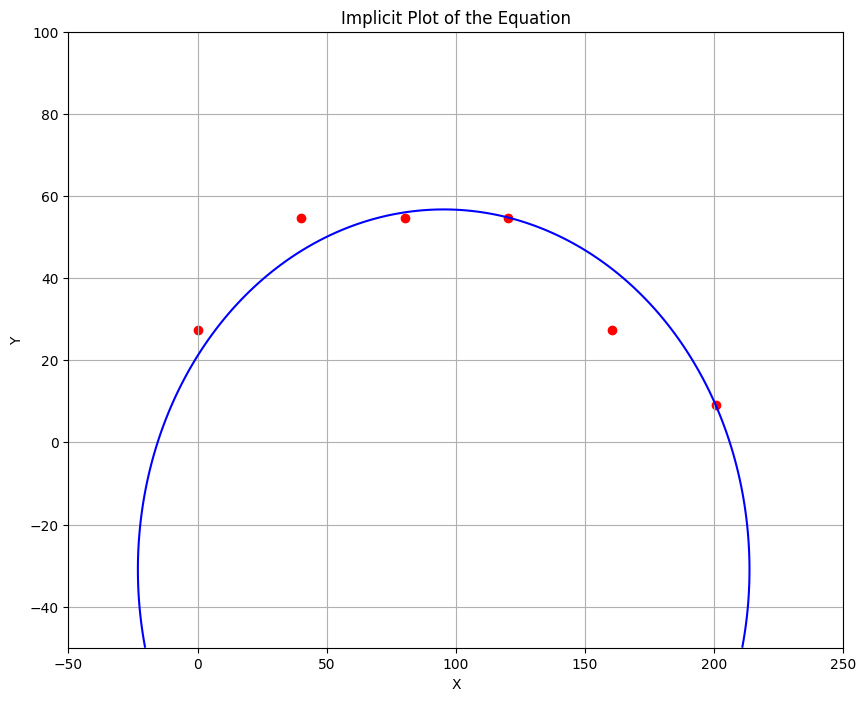

Optimal parameters: a=100.0, b=74.10329797177945, y_0=-30.992176114042845, C=0.3186794656925542, x_0=95.27000000000001
Angle: 62.85317273840304


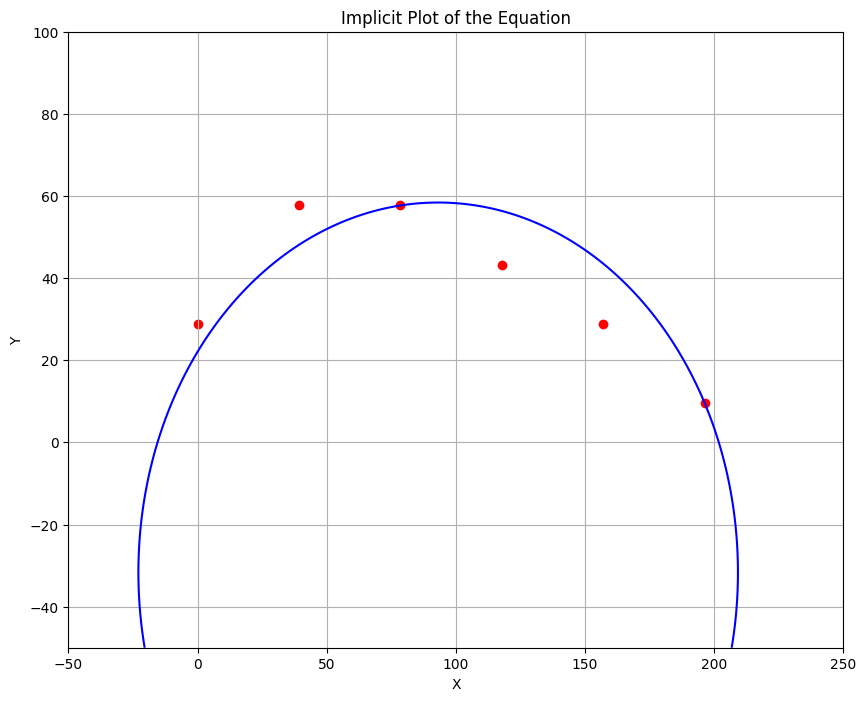

Optimal parameters: a=100.0, b=77.62947865940471, y_0=-31.6731996829044, C=0.31265541179301387, x_0=93.135
Angle: 64.0391664418284


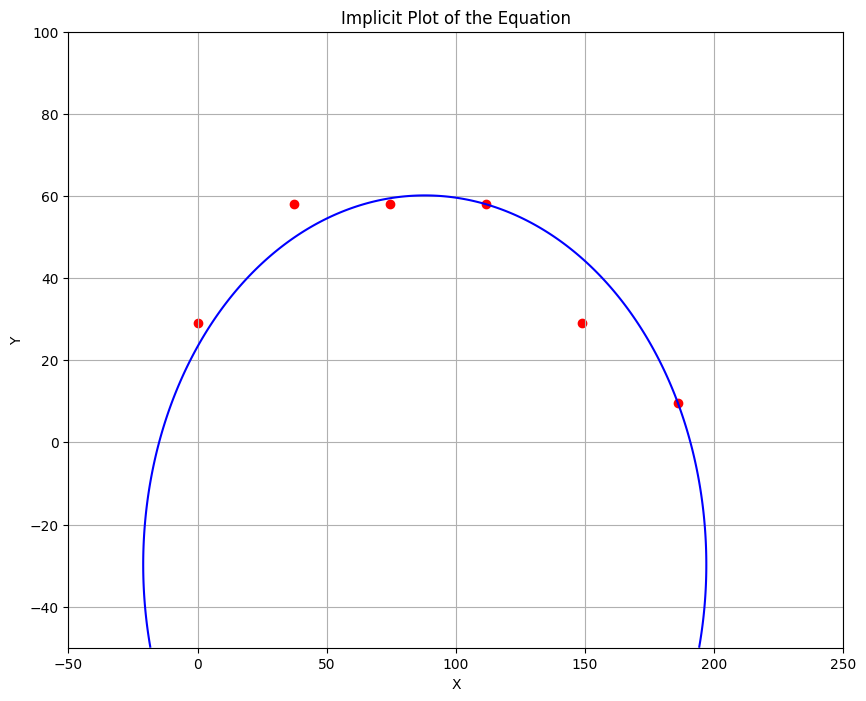

Optimal parameters: a=100.0, b=82.49847341488416, y_0=-29.77510759753069, C=0.2842014375976637, x_0=87.94500000000001
Angle: 66.81542218475086


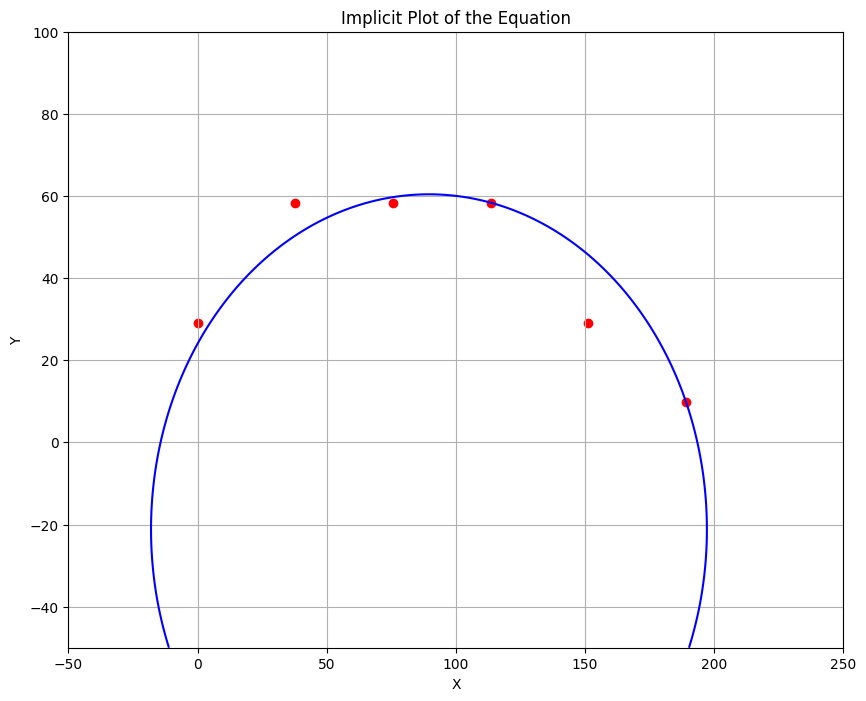

Optimal parameters: a=100.0, b=75.83546653554404, y_0=-21.179036939485915, C=0.2772306583438321, x_0=89.57
Angle: 70.36816330143151


In [20]:
frame_list = []
angle_list = []
x_0_list = []
ellipse_fit_error = 0

# Define the objective function
def objective(params, X, Y):
    a, b, y_0, C, x_0 = params
    summation = np.sum(np.abs((1/a**2)*X**2 - 2*x_0/a**2*X + (1/b**2)*Y**2 - 2*y_0/b**2*Y - C))
    return summation

# Define the implicit equation function
def implicit_eq(X, Y, a, b, y_0, C, x_0):
    return (X**2 / a**2) - (2 * x_0 * X / a**2) + (Y**2 / b**2) - (2 * y_0 * Y / b**2) - C

for frame in range(len(density_positions.keys())):
    
    X_data = np.array(x_data[frame])  # X values
    Y_data = np.array(y_data[frame])  # Y values
    
    x_0 = max(X_data) / 2  # Generally true statement 
    x_0_list.append(x_0)
    x_0_pm = 5

    # Initial guess for the parameters [a, b, y_0, C, x_0]
    initial_guess = [0.4, 0.5, -11.1, 10, x_0]

    # Define bounds for the parameters: (a, b, y_0, C, x_0)
    a_B = (0.1, 100)
    b_B = (0.1, 100)
    y_0_B = (-50, -20)
    C_B = (-100, 100)
    x_0_B = (x_0 - x_0_pm, x_0 + x_0_pm)
    
    bounds = [a_B, b_B, y_0_B, C_B, x_0_B] 

    # Perform the optimization
    result = minimize(objective, initial_guess, args=(X_data, Y_data), method='L-BFGS-B', bounds=bounds)

    # Extract the optimal parameters
    a_opt, b_opt, y_0_opt, C_opt, x_0_opt = result.x

    # Create a grid of points
    x = np.linspace(-50, 250, 400)
    y = np.linspace(-50, 100, 400)
    X, Y = np.meshgrid(x, y)
    Z = implicit_eq(X, Y, a_opt, b_opt, y_0_opt, C_opt, x_0_opt)

    # Plot the contour where Z = 0
    plt.figure(figsize=(10, 8))
    contour = plt.contour(X, Y, Z, levels=[0], colors='blue')
    plt.title('Implicit Plot of the Equation')
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.grid(True)
    plt.scatter(X_data, Y_data, color='red')  # Scatter plot of your data points

    subdirectory = r'C:\Users\jeffs\Downloads\SZvsWorkspaceUpper\SZvsWorkspace\Research\Project2WettingAngle\ProgramOutputs\fitting_methods'
    plot_path = os.path.join(subdirectory, f'best_fit_ellipse{frame}.png')
    #plt.savefig(plot_path)

    plt.show()

    for i in range(len(x_data[frame])):
        ellipse_fit_error += np.abs((1/(a_opt**2))*x_data[frame][i]**2 - (2*x_0_opt/(a_opt**2))*x_data[frame][i] + (1/(b_opt**2))*y_data[frame][i]**2 - (2*y_0_opt)/(b_opt**2)*y_data[frame][i] - C_opt)

    # Angle calculation
    x_a = x_0_opt + math.sqrt(x_0**2 + C_opt * a_opt**2)
    dydx_x_a = b_opt**2*(x_0-x_a)/(a_opt**2*(-y_0_opt))
    theta = abs(math.atan(dydx_x_a)) * 180 / math.pi

    # Creating x & y datas
    frame_list.append(frame)
    angle_list.append(theta)

    print(f"Optimal parameters: a={a_opt}, b={b_opt}, y_0={y_0_opt}, C={C_opt}, x_0={x_0_opt}")
    print(f'Angle: {theta}')

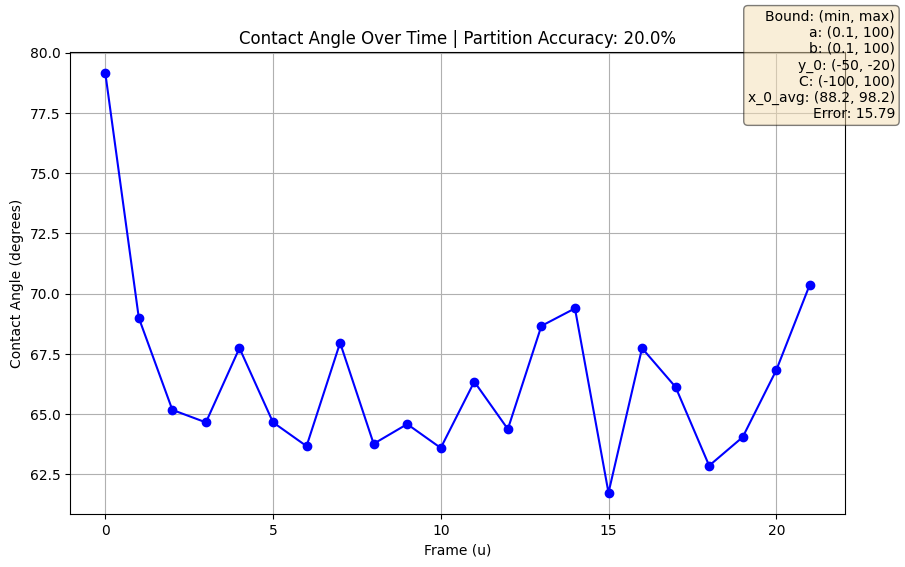

In [21]:
total_angle = 0
x_vals = list(frame_wetting_angle.keys())
y_vals = []

for frame in frame_list:
    total_angle += angle_list[frame]
    y_vals.append(frame_wetting_angle[frame])
    #print(f'Frame: {frame} | Theta: {round(frame_wetting_angle[frame],4)}')

plt.figure(figsize=(10, 6))
plt.plot(frame_list, angle_list, marker='o', linestyle='-', color='b')

# Print out wetting angle for each frame and sum all wetting angles in order to average and create y_val list
values = {
    'Bound': '(min, max)',
    'a': a_B,
    'b': b_B,
    'y_0': y_0_B,
    'C': C_B,
    'x_0_avg': f'{round(sum(x_0_list)/len(x_0_list)-x_0_pm,1),round(sum(x_0_list)/len(x_0_list)+x_0_pm,1)}',
    'Error': round(ellipse_fit_error,2)
}

# Add a text box in the top right corner
textstr = '\n'.join([f'{key}: {value}' for key, value in values.items()])
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)

# Place the text box in the top right corner of the plot
plt.gcf().text(0.95, 0.95, textstr, fontsize=10,
               verticalalignment='top', horizontalalignment='right', bbox=props)


plt.xlabel('Frame (u)')
plt.ylabel('Contact Angle (degrees)')
plt.title(f'Contact Angle Over Time | Partition Accuracy: {partition_percentage *100}%')
plt.grid(True)
plt.show()

95% confidence intervals:
m: [8.490878979586526, 18.564818085425905]
C: [-0.14918198406792316, 3.3281781268120847]
b: [64.5663523823734, 66.8268785835916]
Optimal parameters: m = 13.527848532506216, C = 1.5894980713720808, b = 65.6966154829825


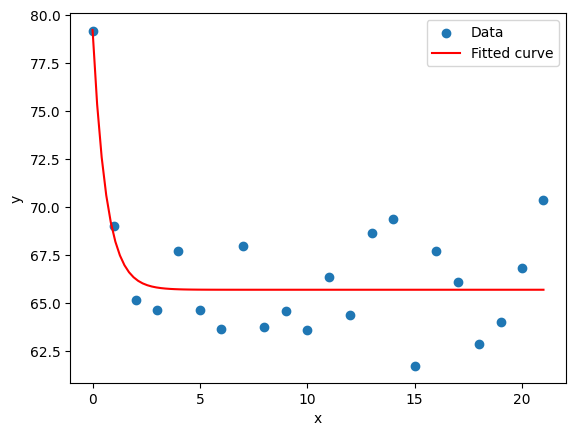

In [22]:
# Given data points
x = frame_list
y = angle_list

# Define the model function
def model(x, m, C, b):
    return m*np.exp(-C * (x)) + b


# Initial guess for the parameters
initial_guess = [10, 0.3, 68]

# Perform the curve fitting
params, covariance = curve_fit(model, x, y, p0=initial_guess)

# Extract errors
standard_errors = np.sqrt(np.diag(covariance))
m_err, C_err, b_err = standard_errors

# Extract the optimal parameters
m_opt, C_opt, b_opt = params

# Calculate the 95% confidence intervals
alpha = 0.05
dof = max(0, len(x) - len(params))  # degrees of freedom
t_val = t.ppf(1 - alpha/2, dof)  # t critical value for 95% confidence

# Confidence intervals
m_ci = [m_opt - t_val * m_err, m_opt + t_val * m_err]
C_ci = [C_opt - t_val * C_err, C_opt + t_val * C_err]
b_ci = [b_opt - t_val * b_err, b_opt + t_val * b_err]

# Print the confidence intervals
print(f"95% confidence intervals:")
print(f"m: {m_ci}")
print(f"C: {C_ci}")
print(f"b: {b_ci}")

# Print the results
print(f"Optimal parameters: m = {m_opt}, C = {C_opt}, b = {b_opt}")

# Plot the data and the fitted curve
plt.scatter(x, y, label='Data')
x_fit = np.linspace(min(x), max(x), 100)
y_fit = model(x_fit, m_opt,  C_opt, b_opt)
plt.plot(x_fit, y_fit, label='Fitted curve', color='red')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()


In [23]:
print(covariance)

[[ 5.79148869  0.25885066 -0.27947197]
 [ 0.25885066  0.69006644  0.12189759]
 [-0.27947197  0.12189759  0.29161554]]


In [24]:
def exponential_decay_equation(m,C,b,x):
    return m * math.e ** (-C * x) + b

In [25]:
equilibrium_contact_angle = exponential_decay_equation(m_opt,C_opt,b_opt,999999)

In [26]:
deviation = 0
for angle in angle_list:
    deviation += (angle - equilibrium_contact_angle)**2
rms_calculation = math.sqrt(deviation/len(angle_list))
print(f'Fluctuation angle: {round(rms_calculation,2)} | Eq angle: {round(equilibrium_contact_angle,2)}')

Fluctuation angle: 3.67 | Eq angle: 65.7


In [27]:
relaxation_time = -1/C_opt * math.log((equilibrium_contact_angle*(1.02) - b_opt) / m_opt)
print(round(relaxation_time,2),round(exponential_decay_equation(m_opt,C_opt,b_opt,relaxation_time),2))

1.47 67.01


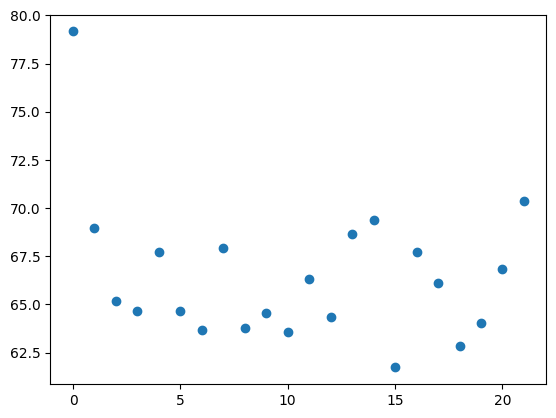

In [28]:
plt.scatter(x, y, label='Data')